# Credit risk analysis for process automation in the banking sector - EDA

**Goal:**

Provide the probability of default for a given customer based on their current applicaion data and/or their registered historical data.

**Data:**

The dataset was provided by the Home Credit Default Risk Challenge on Kaggle. It contains information about customers who applied for a home credit loan, including their application data and historical data from previous applications. The dataset is divided into two parts: the application data and the historical data with pre-split test and train sets.

**Steps:** Iterative in *italic*
1. Load the data
2. Discover and visualize the data
3. Preprocess the data
4. Engineer features
5. Train a baseline model
6. *Additional models*  
7. *Evaluate the models*  
8. *Tune the models*  
9. *Make predictions on the test set*  
10. Submit the predictions to Kaggle
11. Conclusion and next steps

Load necessary libraries and custom helper functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import duckdb

import queries
from helpers import helper as h
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import CountFrequencyEncoder


## 1. Load the data


I used duckdb to load the data tables from the provided csv files.

Reason: 
- DuckDB is optimized for analytical queries and can handle large datasets efficiently.
- It allows for SQL-like queries, which is more intuitive and faster for data exploration and manipulation compared to traditional pandas operations.

The data structure is described on the [Kaggle page](https://www.kaggle.com/competitions/home-credit-default-risk/data) is as follows:

![alt text](misc/home_credit.png)


Initialize the database connection

In [7]:
con = duckdb.connect(database="home_credit.db")

Load csv files into the database using consequent names

In [8]:
base_path = "home-credit-default-risk/"

tables = {
    "application_train": f"{base_path}application_train.csv",
    "application_test": f"{base_path}application_test.csv",
    "bureau": f"{base_path}bureau.csv",
    "bureau_balance": f"{base_path}bureau_balance.csv",
    "pos_cash_balance": f"{base_path}POS_CASH_balance.csv",
    "credit_card_balance": f"{base_path}credit_card_balance.csv",
    "previous_application": f"{base_path}previous_application.csv",
    "installments_payments": f"{base_path}installments_payments.csv"
}

for table, file in tables.items():
    if table not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
        con.execute(f"CREATE TABLE {table} AS SELECT * FROM read_csv_auto('{file}')")

tables_in_duckdb  = con.execute("SHOW TABLES").fetchall()
print("Loaded tables:", tables_in_duckdb)


Loaded tables: [('application_test',), ('application_train',), ('bureau',), ('bureau_balance',), ('bureau_merged_agg',), ('bureau_middle',), ('card_merged_agg',), ('credit_card_balance',), ('inst_merged_agg',), ('installments_payments',), ('pos_cash_balance',), ('pos_merged_agg',), ('prep_data',), ('prev_app_agg',), ('previous_application',)]


## 2. Discover and visualize the data

### 2.1. General approach

To work through the historical data tables, I chose a bottom-up approach.

My goal was to aggregate the given data to a level that I can directly join into the table with the current application data.

**Overview**: 
- Bureau balance aggregated to the level of the bureau data, which can than be aggregated again to the level of the application data.
- Previous application table can be aggregated to the level of the current application data in one step.
- Lower level data from previous applications can be directly aggregated to the level of the current application data OR:
- *Possible improvement: First aggregate by lower-level id, then merge into mid-level table, aggregate again to the top-level* -> Only makes sense if we use the mid-level table and its relationships for feature engineering.

**Note:** 
- As I decided on using a database, I will store the used queries in a separate file for better readability and reusability.
- All new generated features have prefixes from their source table, and descriptive names for better understanding and later determination of the importance of the features / tables.
- I used Data Wrangler to look at the resulting dataframes, so I did not output the checked results to save ink and time.

### 2.2. Aggregating the tables

#### 2.2.1. Bureau balance


Goal: 
- Aggregate by `SK_ID_BUREAU` for future merging into the bureau table
- Create meaningful features for future predictions

Current columns:
- SK_ID_BUREAU: Unique identifier for the bureau balance record
- Month relative to the application date (max 0)
- Status of the credit in given month

Features:
- Proportion of months with a certain status
- Total number of months
- Number of times the status changed -> indicator of late payment


##### 2.2.1.1. Queries

Count the number of occurrences of each status for each SK_ID_BUREAU.

I used the counts here for easier aggregation on the higher level.

*Earlier mistake: I used proportions at this point, but that is not practical as I have to aggregate again on the higher level. I will use the counts for the aggregation and then calculate the proportions in the next step.*


In [9]:
bureau_balance_stat_prop_df = con.execute(queries.bureau_balance_status_query).fetch_df()
bureau_balance_stat_prop_df = pl.from_pandas(bureau_balance_stat_prop_df)

Check if the status changed in the last month.

In [10]:
bureau_balance_stat_change_df = con.execute(queries.bureau_balance_status_change_query).fetch_df()

bureau_balance_stat_change_df = pl.from_pandas(bureau_balance_stat_change_df)

Join tables on `SK_ID_BUREAU`.

In [11]:
bureau_balance_agg_df = bureau_balance_stat_change_df.join(
    bureau_balance_stat_prop_df, on="SK_ID_BUREAU", how="full"
).drop("SK_ID_BUREAU_right")

#### 2.2.2. Bureau

Goal:
- First joint the bureau balance table to the bureau table on `SK_ID_BUREAU`.
- Then aggregate the bureau table to the level of the application data.
- Create meaningful features for future predictions 

In [12]:
bureau_df = con.execute("SELECT * FROM bureau").fetch_df()
bureau_df = pl.from_pandas(bureau_df)

##### 2.2.2.1. Join bureau balance and bureau tables

In [13]:
bureau_middle_df = bureau_df.join(
    bureau_balance_agg_df, on="SK_ID_BUREAU", how="full"
)

In [14]:
bureau_middle_df.head()

SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_BUREAU_right,bureau_balance_status_switches,bureau_balance_total_months_count,bureau_balance_count_status_C,bureau_balance_count_status_X,bureau_balance_count_status_0,bureau_balance_count_status_1,bureau_balance_count_status_2,bureau_balance_count_status_3,bureau_balance_count_status_4,bureau_balance_count_status_5
i64,i64,str,str,i64,i64,f64,f64,f64,i64,f64,f64,f64,f64,str,i64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
215354,5714462,"""Closed""","""currency 1""",-497,0,-153.0,-153.0,null,0,91323.0,0.0,null,0.0,"""Consumer credit""",-131,null,null,null,null,null,null,null,null,null,null,null,null
215354,5714463,"""Active""","""currency 1""",-208,0,1075.0,null,null,0,225000.0,171342.0,null,0.0,"""Credit card""",-20,null,null,null,null,null,null,null,null,null,null,null,null
215354,5714464,"""Active""","""currency 1""",-203,0,528.0,null,null,0,464323.5,null,null,0.0,"""Consumer credit""",-16,null,null,null,null,null,null,null,null,null,null,null,null
215354,5714465,"""Active""","""currency 1""",-203,0,null,null,null,0,90000.0,null,null,0.0,"""Credit card""",-16,null,null,null,null,null,null,null,null,null,null,null,null
215354,5714466,"""Active""","""currency 1""",-629,0,1197.0,null,77674.5,0,2.7e6,null,null,0.0,"""Consumer credit""",-21,null,null,null,null,null,null,null,null,null,null,null,null


Many of the ids do not have information in the bureau balance table.

I created a new feature to indicate if the id has information in the bureau balance table.

In [15]:
bureau_middle_df = bureau_middle_df.with_columns(
    (bureau_middle_df['SK_ID_BUREAU']
     .is_in(bureau_balance_agg_df['SK_ID_BUREAU']))
    .alias('bureau_balance_data_present')
)

In [16]:
bureau_middle_df = bureau_middle_df.drop(["SK_ID_BUREAU", "SK_ID_BUREAU_right"])

Optimize memory usage by downcasting the datatypes of the columns.

In [17]:
bureau_middle_df = h.optimize_memory_usage(bureau_middle_df)

Now we need to aggregate by the current application id.

As we have categorical and string columns, I will convert them to numerical values for easier aggregation.

Creating a new mid-level table that I can query efficiently.

In [19]:
if "bureau_middle" not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
    con.execute("CREATE TABLE bureau_middle AS SELECT * FROM bureau_middle_df")
else:
    print("Table 'bureau_middle' already exists.")

Table 'bureau_middle' already exists.


##### 2.2.2.2. Queries

In [20]:
bureau_frames_to_merge = []

Query to retreive the proportion of the certain status in the bureau table.

In [21]:
bureau_status_df = con.execute(queries.bureau_active_status_query).fetch_df()
bureau_frames_to_merge.append(bureau_status_df)
bureau_status_df.describe()

,SK_ID_CURR,bureau_earlier_credits_count,bureau_pct_Active,bureau_pct_Closed,bureau_pct_Sold,bureau_pct_other
count,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000
mean,278047.300091,5.612709,0.410223,0.585966,0.003797,0.000014
std,102849.568343,4.430354,0.307228,0.307523,0.037425,0.002370
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,188878.500000,2.000000,0.200000,0.400000,0.000000,0.000000
50%,277895.000000,4.000000,0.375000,0.625000,0.000000,0.000000
75%,367184.500000,8.000000,0.600000,0.800000,0.000000,0.000000
max,456255.000000,116.000000,1.000000,1.000000,1.000000,1.000000


Visualizing the features helps identify potential outliers and understand the distribution of the data.

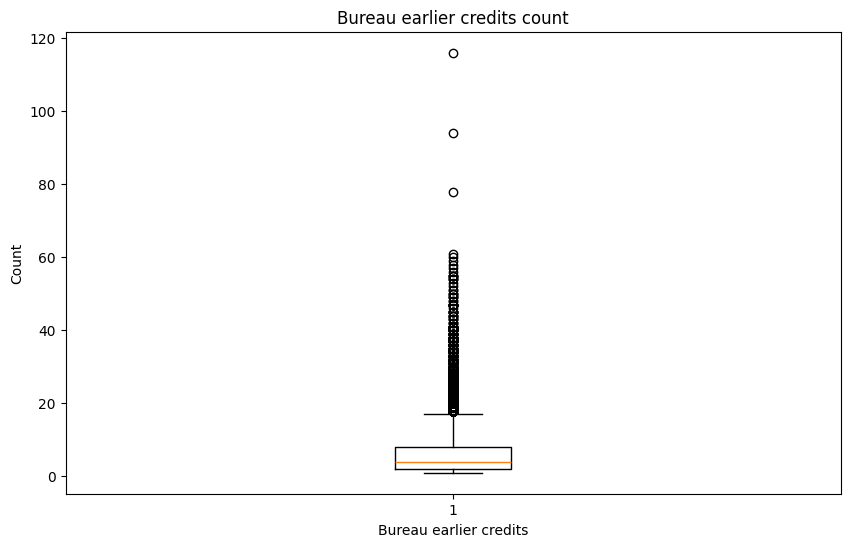

In [22]:
plt.figure(figsize=(10, 6))
plt.title("Bureau earlier credits count")
plt.boxplot(bureau_status_df["bureau_earlier_credits_count"])
plt.ylabel("Count")
plt.xlabel("Bureau earlier credits")
plt.show()

Display status propotions based on application id.


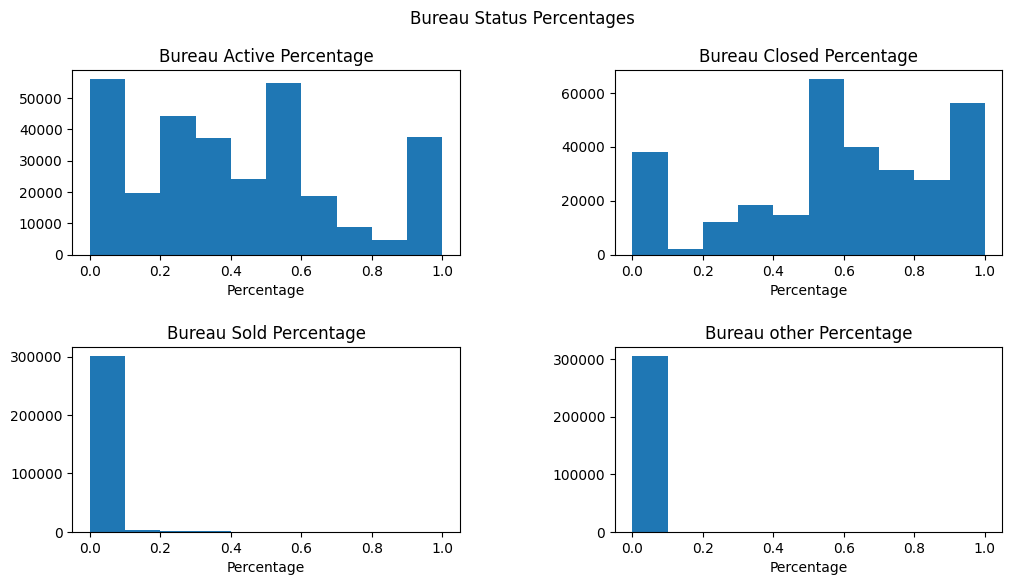

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

fig.suptitle("Bureau Status Percentages")

axs[0, 0].hist(bureau_status_df["bureau_pct_Active"])
axs[0, 0].set_title("Bureau Active Percentage")
axs[0, 0].set_xlabel("Percentage")

axs[0, 1].hist(bureau_status_df["bureau_pct_Closed"])
axs[0, 1].set_title("Bureau Closed Percentage")
axs[0, 1].set_xlabel("Percentage")

axs[1, 0].hist(bureau_status_df["bureau_pct_Sold"])
axs[1, 0].set_title("Bureau Sold Percentage")
axs[1, 0].set_xlabel("Percentage")

axs[1, 1].hist(bureau_status_df["bureau_pct_other"])
axs[1, 1].set_title("Bureau other Percentage")
axs[1, 1].set_xlabel("Percentage")

plt.subplots_adjust(hspace=0.5, wspace=0.4) 
plt.show()



Query to one-hot encode currencies and check if an applicant had multiple currencies in the bureau table, and if they had a currency that is not the most dominant category.

In [24]:
bureau_currency_df = con.execute(queries.bureau_currency_query).fetch_df()
bureau_frames_to_merge.append(bureau_currency_df)
bureau_currency_df.describe()

,SK_ID_CURR,bureau_count_currency_1,bureau_count_currency_2,bureau_count_currency_3,bureau_count_currency_4,bureau_multiple_currencies,bureau_non_dominant_currency
count,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000
mean,278047.300091,5.608104,0.004002,0.000569,0.000033,0.003505,0.003630
std,102849.568343,4.426992,0.079177,0.026199,0.005718,0.059103,0.060138
min,100001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188878.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277895.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367184.500000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,116.000000,6.000000,3.000000,1.000000,1.000000,1.000000


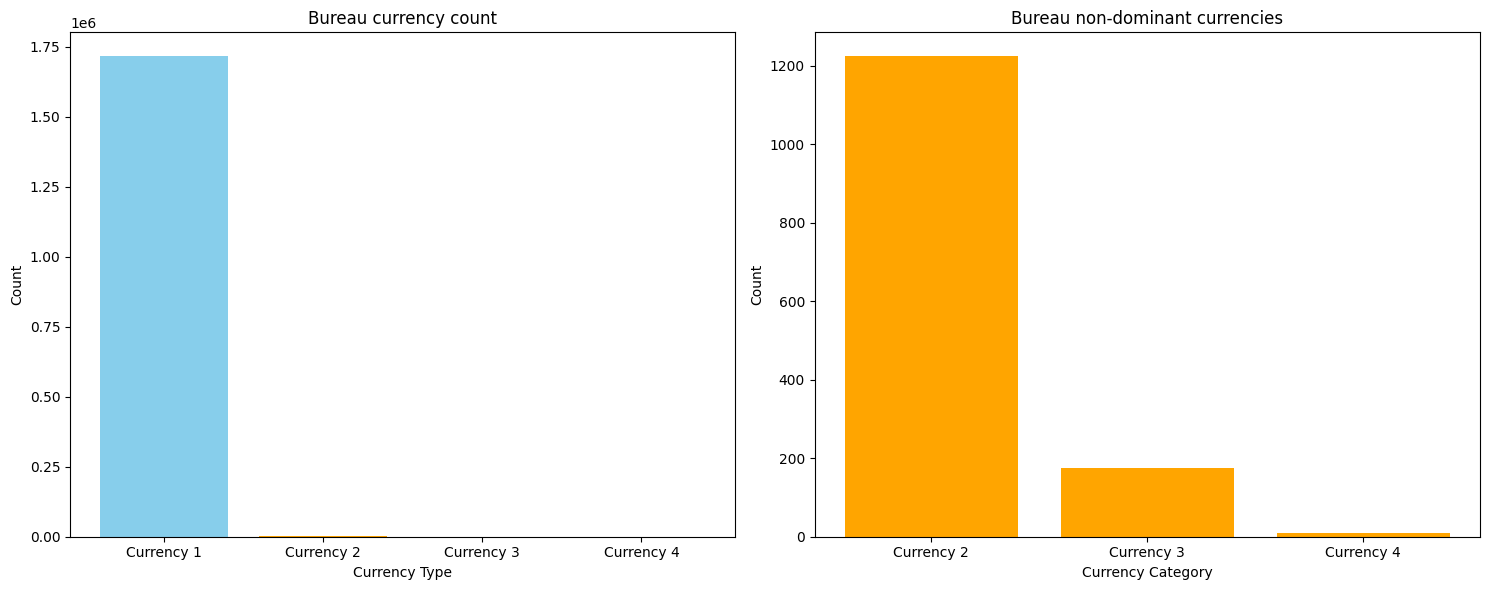

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].set_title("Bureau currency count")
axs[0].bar(
    ["Currency 1", "Currency 2", "Currency 3", "Currency 4"],
    bureau_currency_df[["bureau_count_currency_1", "bureau_count_currency_2", "bureau_count_currency_3", "bureau_count_currency_4"]].sum(),
    color=["skyblue", "orange", "orange", "orange"]
)
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Currency Type")

axs[1].set_title("Bureau non-dominant currencies")
axs[1].bar(
    ["Currency 2", "Currency 3", "Currency 4"],
    bureau_currency_df[["bureau_count_currency_2", "bureau_count_currency_3", "bureau_count_currency_4"]].sum(),
    color="orange"
)
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Currency Category")

plt.tight_layout()
plt.show()

Query to see with which frequency the applicant applied for a loan before.

In [26]:
bureau_app_days_df = con.execute(queries.bureau_credit_days_query).fetch_df()
bureau_frames_to_merge.append(bureau_app_days_df)
bureau_app_days_df.describe()

,SK_ID_CURR,bureau_days_credit_diff_avg,bureau_days_credit_diff_min,bureau_days_credit_diff_max
count,264291.000000,264291.000000,264291.000000,264291.000000
mean,278272.351749,382.649752,157.246259,772.036475
std,102879.554051,346.658179,350.168204,503.929511
min,100001.000000,0.000000,0.000000,0.000000
25%,189067.500000,178.375000,1.000000,401.000000
50%,278219.000000,284.000000,19.000000,678.000000
75%,367431.000000,462.200000,141.000000,1044.000000
max,456255.000000,2889.000000,2889.000000,2895.000000


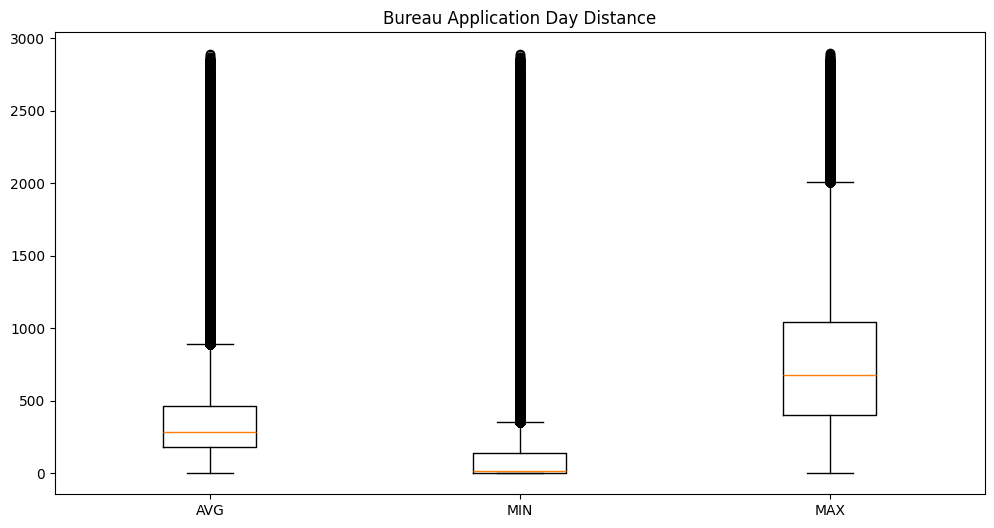

In [27]:
plt.figure(figsize=(12, 6))
plt.boxplot(bureau_app_days_df.drop(columns='SK_ID_CURR').values, tick_labels=['AVG', 'MIN', 'MAX'])
plt.title("Bureau Application Day Distance")
plt.show()

In [28]:
import importlib

importlib.reload(queries)

<module 'queries' from 'c:\\Users\\Kata\\source\\repos\\kherna-DS.v2.5.3.4.1\\queries.py'>

Query to check the difference between the set and actual enddate.

In [29]:
bureau_enddate_df = con.execute(queries.bureau_enddate_query).fetch_df()
bureau_frames_to_merge.append(bureau_enddate_df)
bureau_enddate_df.describe()

,SK_ID_CURR,bureau_enddate_diff_days_avg,bureau_enddate_diff_days_min,bureau_enddate_diff_days_max
count,266403.000000,266403.000000,266403.000000,266403.000000
mean,278053.932805,431.531894,25.842085,1499.591716
std,102834.500083,1657.672597,1132.933873,5211.284709
min,100001.000000,-2573.000000,-2749.000000,-2573.000000
25%,188836.500000,0.000000,-28.000000,0.000000
50%,277965.000000,30.000000,-1.000000,118.000000
75%,367207.500000,247.200000,0.000000,732.000000
max,456255.000000,33357.000000,33357.000000,33893.000000


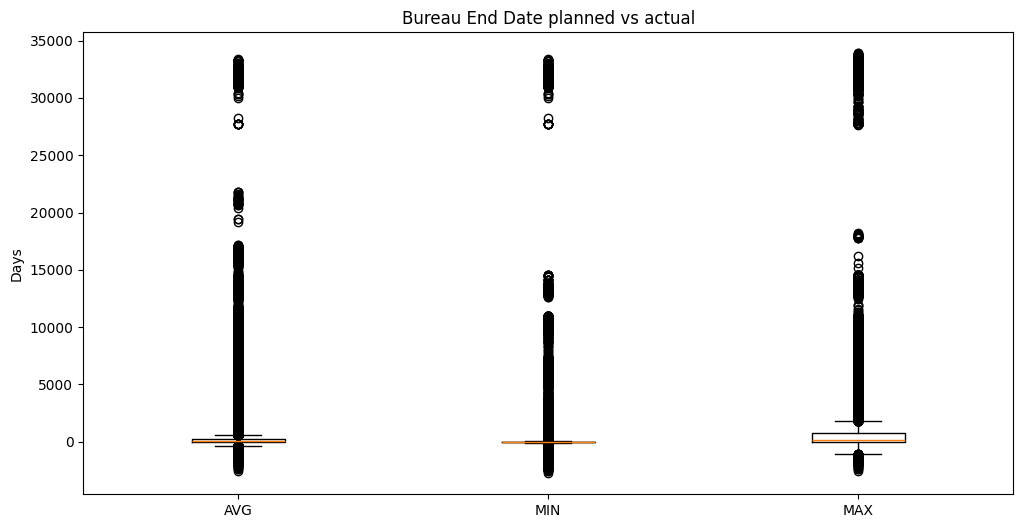

In [30]:
plt.figure(figsize=(12, 6))
plt.boxplot(x=[bureau_enddate_df[col].dropna() for col in bureau_enddate_df.columns if col != 'SK_ID_CURR'], 
            tick_labels=['AVG', 'MIN', 'MAX'])
plt.title("Bureau End Date planned vs actual")
plt.ylabel("Days")
plt.show()

I removed extreme outliers from the `DAYS_CREDIT_ENDDATE` column, as it is unrealistic that we have a digital record of a loan that was supposed to be paid back 100 years ago.

The loan enddates 90 years into the future are not realistic either, but I left them in the dataset for now, as they might be valid records for firms, cities or special circumstances.

**Note:** 

I only filtered the outlier column, I decided not to remove the whole applicant record, as it might just lead to an unneccessary loss of information.


Query to check overdue days at the time of the application.

In [31]:
bureau_overdue_days_df = con.execute(queries.bureau_overdue_days_query).fetch_df()
bureau_frames_to_merge.append(bureau_overdue_days_df)
bureau_overdue_days_df.describe()

,SK_ID_CURR,bureau_credit_day_overdue_avg,bureau_credit_day_overdue_min,bureau_credit_day_overdue_max,bureau_credit_day_overdue_sum
count,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000
mean,278047.300091,0.965926,0.152359,4.436629,4.592130
std,102849.568343,24.957209,16.492305,85.573591,88.812933
min,100001.000000,0.000000,0.000000,0.000000,0.000000
25%,188878.500000,0.000000,0.000000,0.000000,0.000000
50%,277895.000000,0.000000,0.000000,0.000000,0.000000
75%,367184.500000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,2776.000000,2776.000000,2792.000000,5250.000000


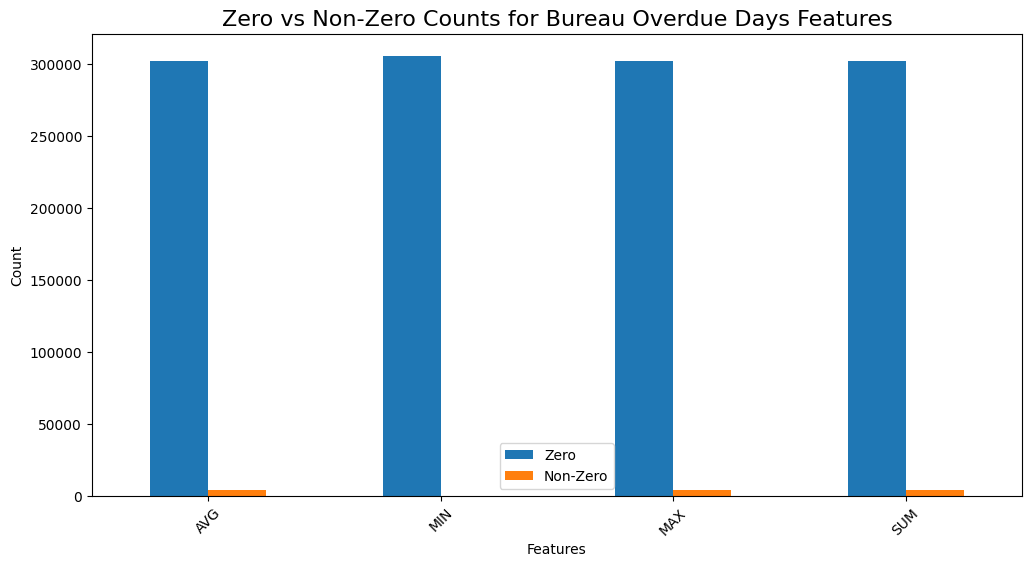

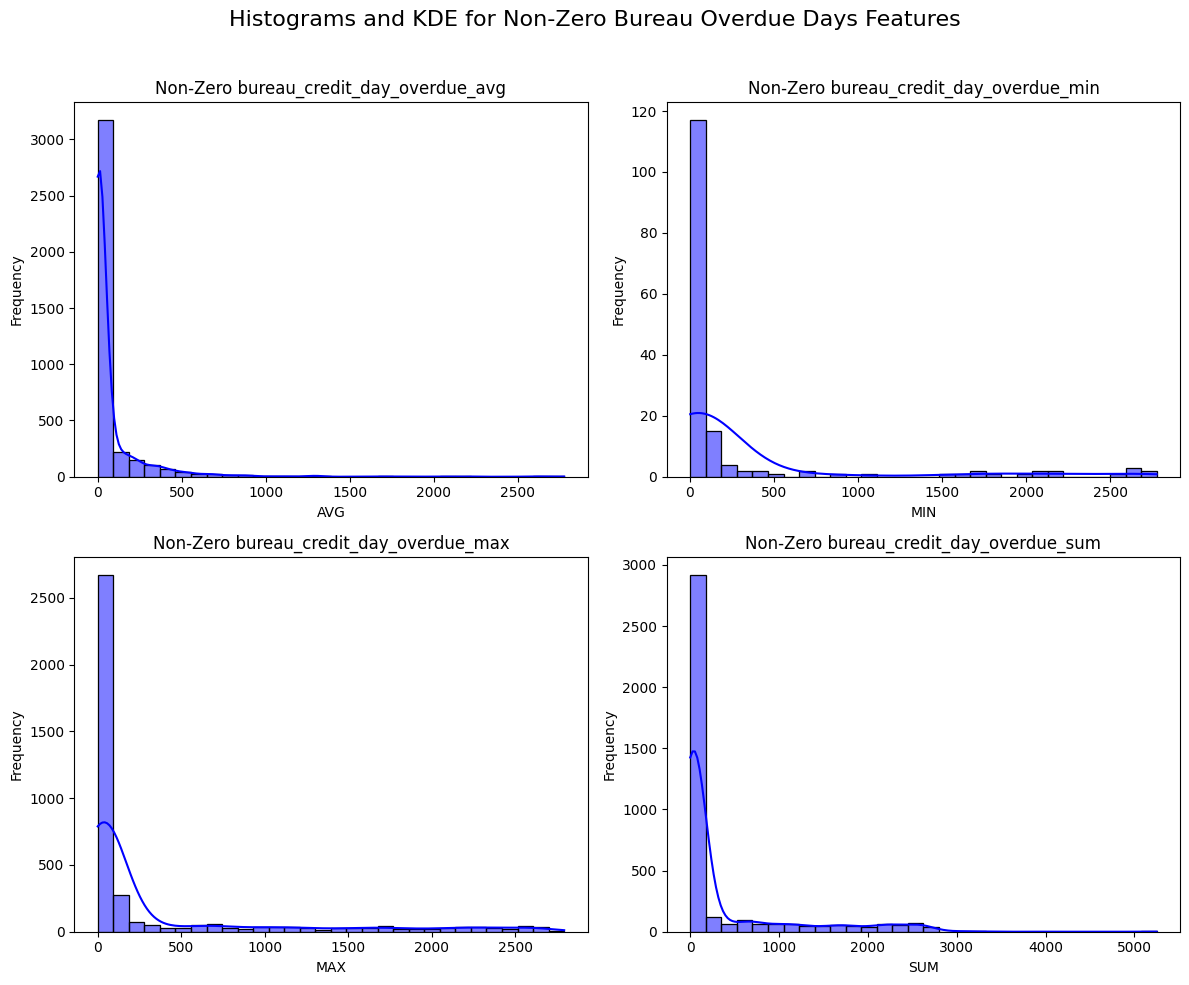

In [32]:
columns_to_plot = bureau_overdue_days_df.drop(columns='SK_ID_CURR')
zero_nonzero_counts = columns_to_plot.apply(lambda col: pd.Series([sum(col == 0), sum(col != 0)]), axis=0)
zero_nonzero_counts.index = ["Zero", "Non-Zero"]
zero_nonzero_counts = zero_nonzero_counts.T

zero_nonzero_counts.plot(kind="bar", figsize=(12, 6), rot=0)
plt.title("Zero vs Non-Zero Counts for Bureau Overdue Days Features", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Features")
plt.xticks(ticks=range(len(zero_nonzero_counts.index)), labels=[col.split('_')[-1].upper() for col in zero_nonzero_counts.index], rotation=45)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Histograms and KDE for Non-Zero Bureau Overdue Days Features", fontsize=16)

for ax, column in zip(axs.flatten(), columns_to_plot.columns):
    non_zero_values = columns_to_plot[column][columns_to_plot[column] != 0]
    if not non_zero_values.empty:
        sns.histplot(non_zero_values, kde=True, bins=30, color="blue", ax=ax)
        ax.set_title(f"Non-Zero {column}", fontsize=12)
        ax.set_xlabel(column.split('_')[-1].upper())
        ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Query to get the total debt and the amount overdue.

In [33]:
bureau_credit_debt_sum_df = con.execute(queries.bureau_credit_debt_sum_query).fetch_df()
bureau_frames_to_merge.append(bureau_credit_debt_sum_df)
bureau_credit_debt_sum_df.describe()

,SK_ID_CURR,bureau_total_credit_debt,bureau_avg_credit_debt,bureau_min_credit_debt,bureau_max_credit_debt,bureau_total_credit_overdue,bureau_avg_credit_overdue,bureau_min_credit_overdue,bureau_max_credit_overdue
count,305811.000000,2.974390e+05,2.974390e+05,2.974390e+05,2.974390e+05,3.058110e+05,3.058110e+05,3.058110e+05,3.058110e+05
mean,278047.300091,6.723199e+05,1.616341e+05,3.971807e+04,5.300396e+05,2.127933e+02,4.595072e+01,1.144253e+01,1.764095e+02
std,102849.568343,1.659898e+06,5.367677e+05,4.165223e+05,1.357630e+06,1.569161e+04,4.956640e+03,3.831422e+03,1.368650e+04
min,100001.000000,-6.981558e+06,-1.083615e+06,-4.705600e+06,-2.595965e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,188878.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,277895.000000,1.897470e+05,4.476038e+04,0.000000e+00,1.526175e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,367184.500000,7.008052e+05,1.436004e+05,0.000000e+00,5.059968e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,456255.000000,3.344983e+08,5.175000e+07,5.175000e+07,1.701000e+08,3.756681e+06,1.617404e+06,1.617404e+06,3.756681e+06


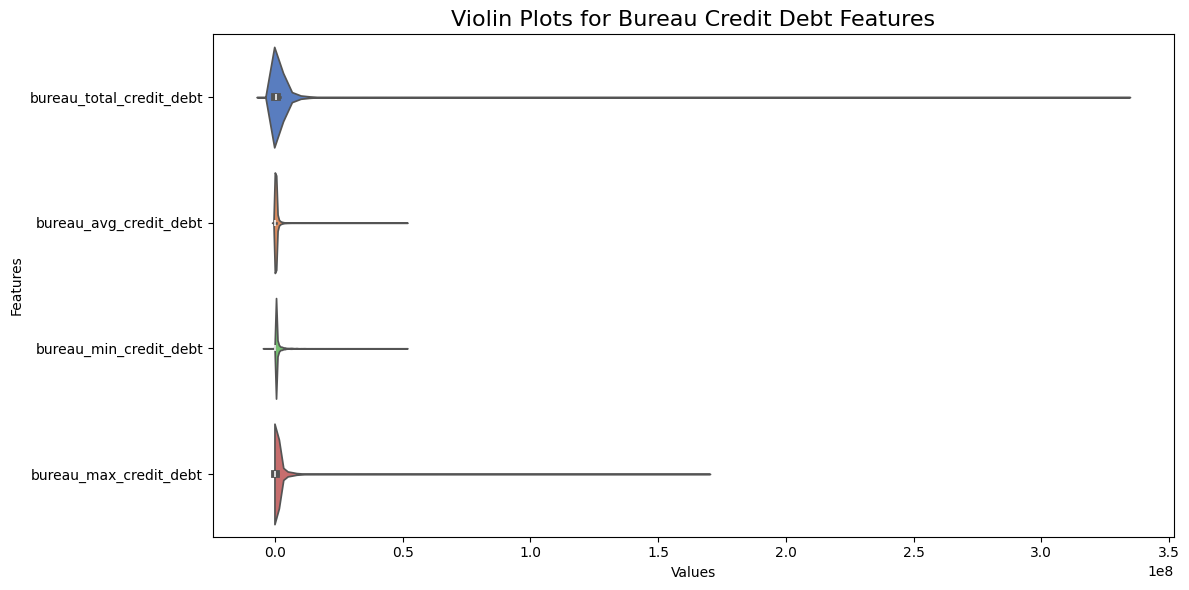

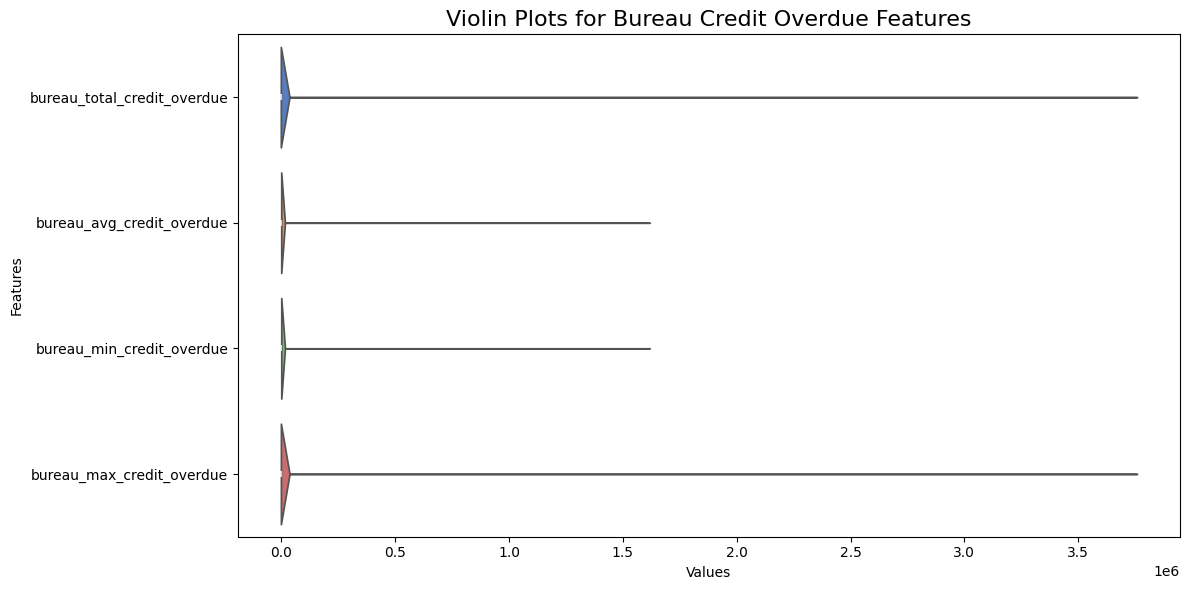

In [34]:
columns_to_plot = bureau_credit_debt_sum_df.drop(columns=['SK_ID_CURR'])

columns_to_plot = columns_to_plot.dropna()

plt.figure(figsize=(12, 6))
sns.violinplot(data=columns_to_plot.iloc[:, :4], orient='h', palette='muted')
plt.title("Violin Plots for Bureau Credit Debt Features", fontsize=16)
plt.xlabel("Values")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=columns_to_plot.iloc[:, 4:], orient='h', palette='muted')
plt.title("Violin Plots for Bureau Credit Overdue Features", fontsize=16)
plt.xlabel("Values")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Query go get the total credit, the debt and the proportion left at the time of the application.

In [36]:
bureau_debt_left_df = con.execute(queries.bureau_credit_debt_left_query).fetch_df()
bureau_frames_to_merge.append(bureau_debt_left_df)
bureau_debt_left_df.describe()

,SK_ID_CURR,bureau_total_credit_sum,bureau_total_credit_debt,bureau_proportion_left
count,305811.000000,3.058090e+05,2.974390e+05,296292.000000
mean,278047.300091,1.992479e+06,6.723199e+05,0.709918
std,102849.568343,4.165831e+06,1.659898e+06,0.435214
min,100001.000000,0.000000e+00,-6.981558e+06,-6.789100
25%,188878.500000,3.469815e+05,0.000000e+00,0.509419
50%,277895.000000,9.788310e+05,1.897470e+05,0.775370
75%,367184.500000,2.345121e+06,7.008052e+05,1.000000
max,456255.000000,1.017958e+09,3.344983e+08,176.289231


There is an extreme outlier, as someone has a multiplier of 176 times their original credit amount as remaining debt.

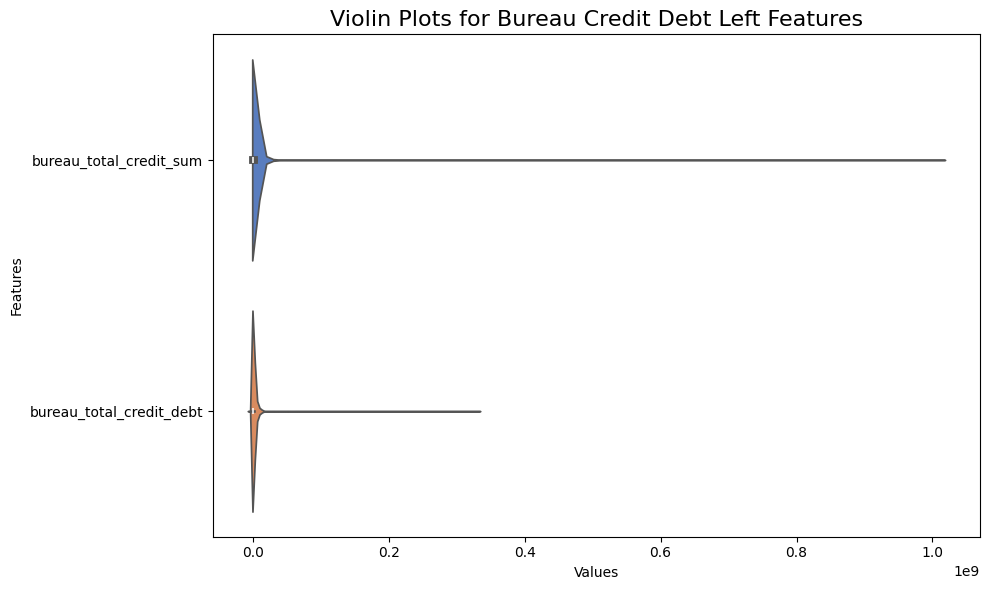

In [37]:
columns_to_plot = bureau_debt_left_df.drop(columns=['SK_ID_CURR'])
columns_to_plot = columns_to_plot.dropna()
plt.figure(figsize=(10, 6))
sns.violinplot(data=columns_to_plot.iloc[:, :2], orient='h', palette='muted')
plt.title("Violin Plots for Bureau Credit Debt Left Features", fontsize=16)
plt.xlabel("Values")
plt.ylabel("Features")
plt.tight_layout()

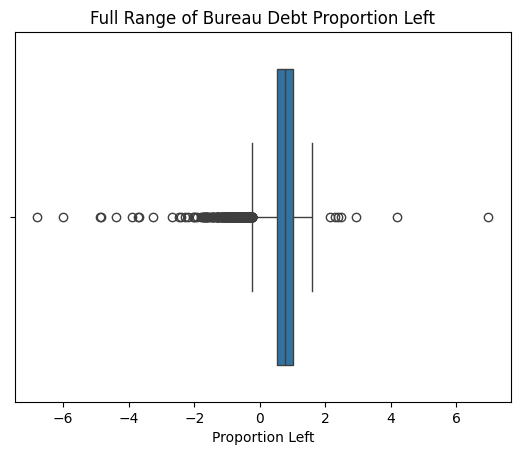

In [38]:
bureau_debt_left_df['bureau_proportion_left'] = bureau_debt_left_df['bureau_proportion_left'].apply(lambda x: np.nan if x > 20 else x)

sns.boxplot(x=bureau_debt_left_df['bureau_proportion_left'])
plt.title("Full Range of Bureau Debt Proportion Left")
plt.xlabel("Proportion Left")
plt.show()

In [39]:
bureau_amt_discovery_df = con.execute("""SELECT 
            AMT_CREDIT_SUM,
            AMT_CREDIT_SUM_DEBT,
            AMT_CREDIT_SUM_LIMIT,
            AMT_CREDIT_SUM_OVERDUE,
            FROM
            bureau
            """).fetch_df()

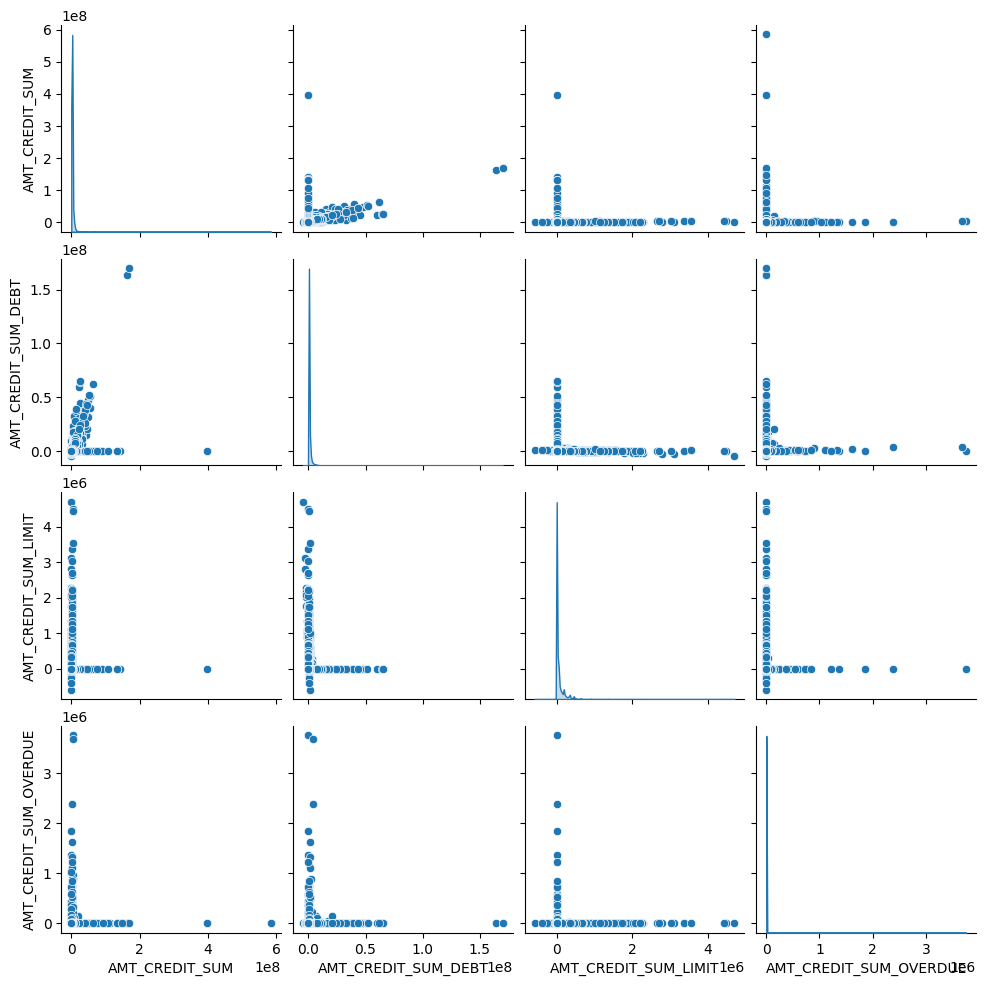

In [40]:
sns.pairplot(bureau_amt_discovery_df, diag_kind='kde')

In [41]:
print(f'Correlation Coefficient - Pearson:', bureau_amt_discovery_df[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].corr(method='pearson').iloc[0, 1])

Correlation Coefficient - Pearson: 0.6834194239139904


`AMT_CREDIT_SUM` and `AMT_CREDIT_SUM_DEBT` are the total credit and the total debt at the time of the application.

They show a positive linear correlation, so I will use them to impute the missing values in the `AMT_CREDIT_SUM_DEBT` column.

In [ ]:
lin_reg_bureau_debt = LinearRegression()

bureau_amt_discovery_df_clean = bureau_amt_discovery_df.dropna(subset=['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT'])

X = bureau_amt_discovery_df_clean[['AMT_CREDIT_SUM']]
y = bureau_amt_discovery_df_clean['AMT_CREDIT_SUM_DEBT']

lin_reg_bureau_debt.fit(X, y)

LinearRegression()

In [43]:
missing_indices = bureau_amt_discovery_df['AMT_CREDIT_SUM_DEBT'].isna()
bureau_amt_discovery_df.loc[missing_indices, 'AMT_CREDIT_SUM_DEBT'] = lin_reg_bureau_debt.predict(
    bureau_amt_discovery_df.loc[missing_indices, ['AMT_CREDIT_SUM']]
)

Query to get the maximal amount overdue, max card limit and amount of prolongations.

In [44]:
bureau_prolong_max_debt_df = con.execute(queries.bureau_prolong_max_debt_query).fetch_df()
bureau_frames_to_merge.append(bureau_prolong_max_debt_df)
bureau_prolong_max_debt_df.describe()

,SK_ID_CURR,bureau_max_overdue,bureau_prolong_count,bureau_max_card_limit
count,305811.000000,2.129710e+05,305811.000000,2.805030e+05
mean,278047.300091,9.012276e+03,0.035980,2.188811e+04
std,102849.568343,3.431858e+05,0.232951,8.454536e+04
min,100001.000000,0.000000e+00,0.000000,-1.747035e+03
25%,188878.500000,0.000000e+00,0.000000,0.000000e+00
50%,277895.000000,0.000000e+00,0.000000,0.000000e+00
75%,367184.500000,5.749065e+03,0.000000,0.000000e+00
max,456255.000000,1.159872e+08,9.000000,4.705600e+06


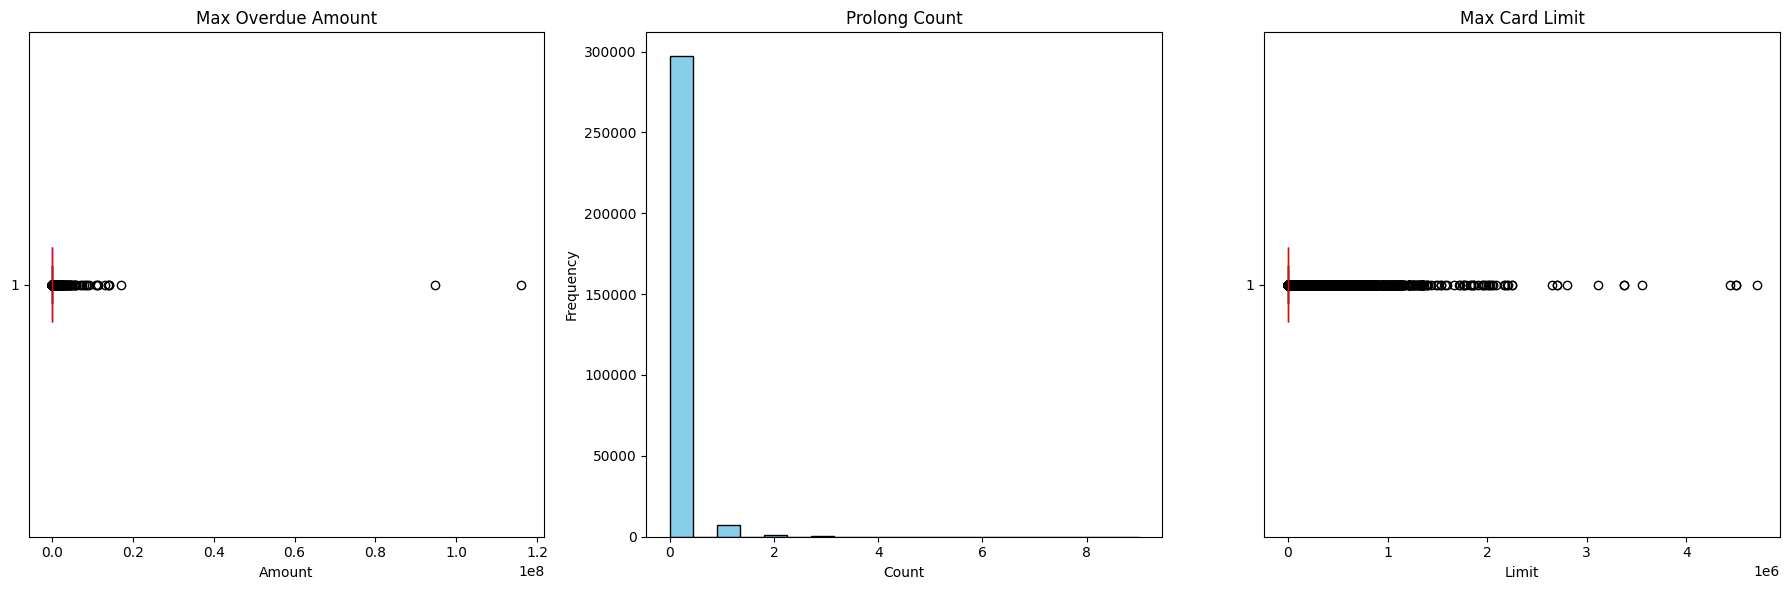

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharex=False, sharey=False)

columns_to_plot = bureau_prolong_max_debt_df.drop(columns='SK_ID_CURR').columns

axes[0].boxplot(
    bureau_prolong_max_debt_df['bureau_max_overdue'].dropna(),
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red')
)
axes[0].set_title('Max Overdue Amount')
axes[0].set_xlabel('Amount')

axes[1].hist(
    bureau_prolong_max_debt_df['bureau_prolong_count'].dropna(),
    bins=20,
    color='skyblue',
    edgecolor='black'
)
axes[1].set_title('Prolong Count')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Frequency')

axes[2].boxplot(
    bureau_prolong_max_debt_df['bureau_max_card_limit'].dropna(),
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='lightgreen', color='green'),
    medianprops=dict(color='red')
)
axes[2].set_title('Max Card Limit')
axes[2].set_xlabel('Limit')

plt.tight_layout()
plt.show()



Remove outliers from `bureau_max_overdue` and `bureau_max_card_limit` columns.

In [46]:
bureau_prolong_max_debt_df.loc[bureau_prolong_max_debt_df['bureau_max_overdue'] > 80000000, 'bureau_max_overdue'] = np.nan
bureau_prolong_max_debt_df.loc[bureau_prolong_max_debt_df['bureau_max_card_limit'] > 4000000, 'bureau_max_card_limit'] = np.nan

Query to get credit type and one-hot encode them.

The top 3 categories are:
- Consumer credit 73%
- Credit card 23%
- Car loan 2%

The other 12 categories make up 2% in total, so I categrized them as "other" for easier handling.


In [47]:
bureau_credit_type_df = con.execute(queries.bureau_credit_type_query).fetch_df()
bureau_frames_to_merge.append(bureau_credit_type_df)
bureau_credit_type_df.describe()

,SK_ID_CURR,bureau_credit_type_consumer_credit,bureau_credit_type_credit_card,bureau_credit_type_car_loan,bureau_credit_type_other
count,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000
mean,278047.300091,4.092773,1.315175,0.090546,0.114214
std,102849.568343,3.534528,1.512766,0.351227,0.620420
min,100001.000000,0.000000,0.000000,0.000000,0.000000
25%,188878.500000,2.000000,0.000000,0.000000,0.000000
50%,277895.000000,3.000000,1.000000,0.000000,0.000000
75%,367184.500000,6.000000,2.000000,0.000000,0.000000
max,456255.000000,86.000000,22.000000,10.000000,79.000000


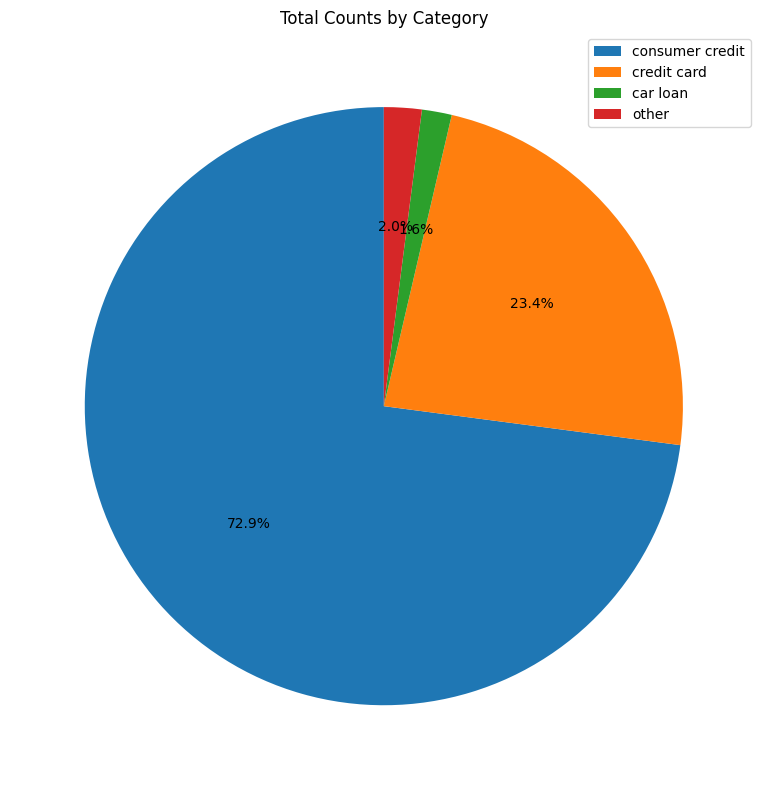

In [48]:
category_totals = bureau_credit_type_df.drop(columns='SK_ID_CURR').sum()

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    category_totals, labels=None, autopct='%1.1f%%', startangle=90
)
plt.title('Total Counts by Category')
plt.axis()
plt.tight_layout()

labels = [label.replace('bureau_credit_type_', '').replace('_', ' ') for label in category_totals.index]
plt.legend(labels=labels, loc="best")

plt.show()

Query to get the latest update on each current application relative to the application date.

In [49]:
bureau_credit_update_df = con.execute(queries.bureau_credit_update_query).fetch_df()
bureau_frames_to_merge.append(bureau_credit_update_df)
bureau_credit_update_df.describe()

,SK_ID_CURR,bureau_last_credit_update
count,305811.000000,305811.000000
mean,278047.300091,-139.313717
std,102849.568343,344.793947
min,100001.000000,-41890.000000
25%,188878.500000,-49.000000
50%,277895.000000,-18.000000
75%,367184.500000,-9.000000
max,456255.000000,372.000000


Removing the one extreme outlier from the `bureau_days_update` column, as it is unrealistic that the last update took place more than 100 years before the application date.

It is interesting to note that there is an update supposedly a year after the application date, which is not realistic either.

In [50]:
bureau_credit_update_df.loc[bureau_credit_update_df['bureau_last_credit_update'] < -40000, 'bureau_last_credit_update'] = np.nan
bureau_credit_update_df.loc[bureau_credit_update_df['bureau_last_credit_update'] > 14, 'bureau_last_credit_update'] = np.nan

<Axes: >

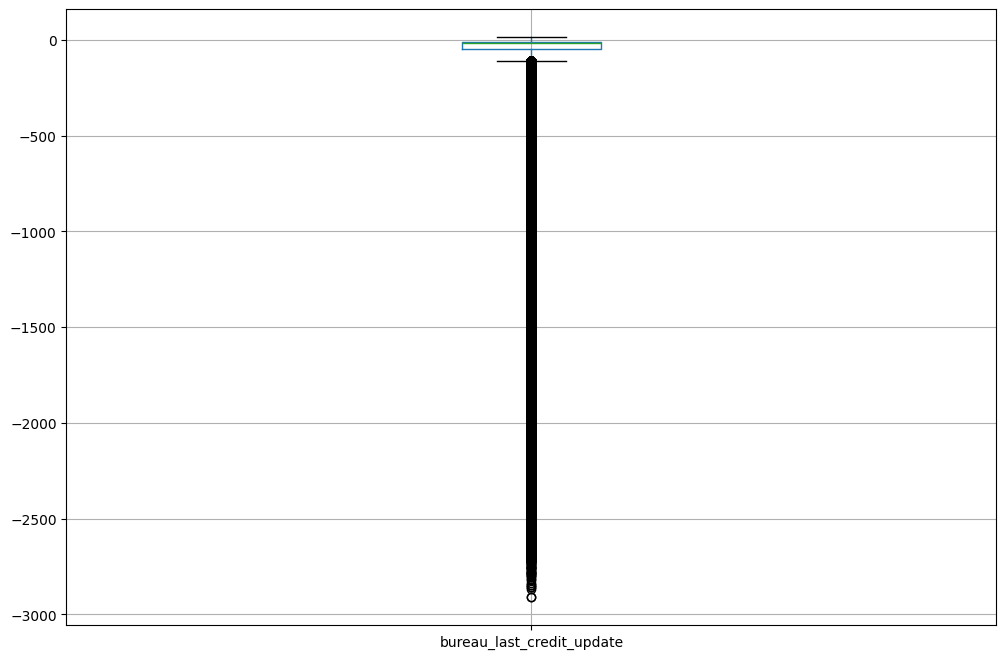

In [51]:
bureau_credit_update_df.drop(columns='SK_ID_CURR').boxplot(figsize=(12, 8))

Query to get the maximal annuity for both active and closed loans per current application.

In [52]:
bureau_annuity_df = con.execute(queries.bureau_annuity_query).fetch_df()
bureau_frames_to_merge.append(bureau_annuity_df)
bureau_annuity_df.describe()

,SK_ID_CURR,bureau_max_active_annuity,bureau_max_closed_annuity
count,305811.000000,9.272600e+04,9.519700e+04
mean,278047.300091,2.662426e+04,2.961504e+04
std,102849.568343,2.580534e+05,6.732444e+05
min,100001.000000,0.000000e+00,0.000000e+00
25%,188878.500000,3.937500e+03,0.000000e+00
50%,277895.000000,1.381500e+04,0.000000e+00
75%,367184.500000,2.943000e+04,1.562013e+04
max,456255.000000,5.684498e+07,1.184534e+08


The maximal values are higher than the IQR3 by a factor of at least 100, so I will remove them from the dataset.

In [53]:
bureau_annuity_df.loc[bureau_annuity_df['bureau_max_active_annuity'] > 50000, 'bureau_max_active_annuity'] = np.nan
bureau_annuity_df.loc[bureau_annuity_df['bureau_max_closed_annuity'] >  30000, 'bureau_max_closed_annuity'] = np.nan

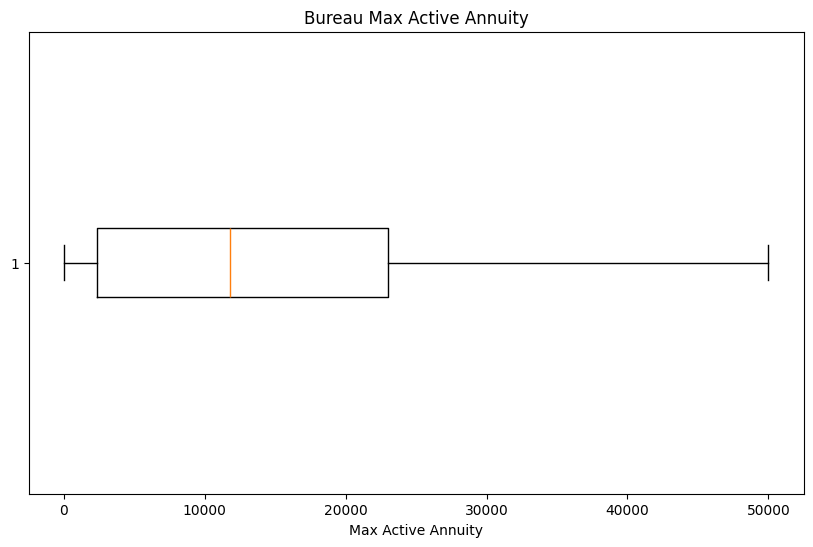

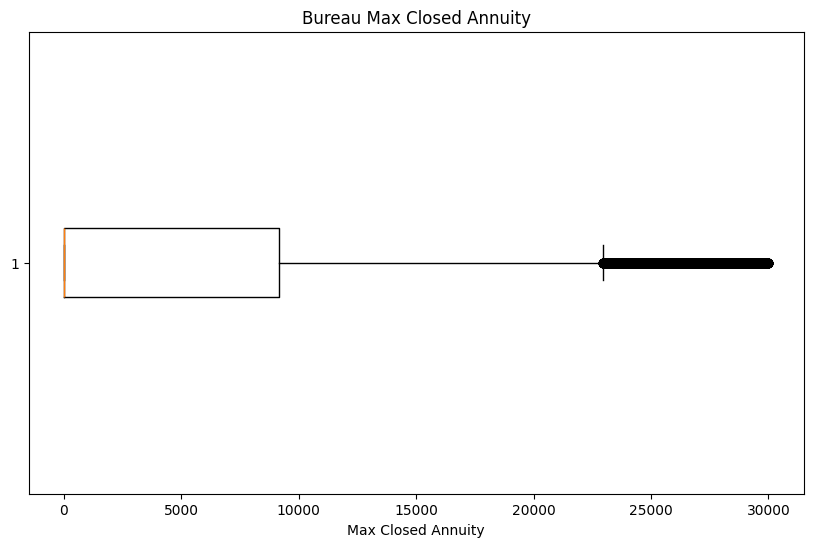

In [54]:
plt.figure(figsize=(10, 6))
plt.title("Bureau Max Active Annuity")
plt.boxplot(bureau_annuity_df['bureau_max_active_annuity'].dropna().values, vert=False)
plt.xlabel("Max Active Annuity")
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Bureau Max Closed Annuity")
plt.boxplot(bureau_annuity_df['bureau_max_closed_annuity'].dropna().values, vert=False)
plt.xlabel("Max Closed Annuity")
plt.show()


Query to aggregate bureau balance features to the level of the bureau table.

- Categorize status: 
    - 0: never late
    - 1: once late
    - 2+ : multiple times late
    - C: closed
    - X: unknown status
- Summarize the number of switches
- Weighted average of status switch per month:
    - more switches indicate more instability in the payment behavior
    - weighting for time effect


In [55]:
bureau_balance_final_agg_df = con.execute(queries.bureau_balance_agg_query).fetch_df()
bureau_frames_to_merge.append(bureau_balance_final_agg_df)
bureau_balance_final_agg_df.describe()

,SK_ID_CURR,bureau_balance_status_switches_sum,bureau_balance_switches_per_month_weighted,bureau_balance_count_status_closed,bureau_balance_count_status_unknown,bureau_balance_count_status_never_late,bureau_balance_count_status_once_late,bureau_balance_count_status_repeated_late
count,305811.0,134254.000000,134254.000000,1.342540e+05,134254.000000,134254.000000,134254.000000,134254.000000
mean,278047.300091,14.383698,0.100238,1.016506e+02,43.279768,55.860585,1.805138,0.749296
std,102849.568343,208.673575,0.110762,5.709885e+03,1903.052879,843.025526,34.675774,45.148899
min,100001.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,188878.5,3.000000,0.033333,8.000000e+00,2.000000,15.000000,0.000000,0.000000
50%,277895.0,8.000000,0.062500,4.700000e+01,12.000000,36.000000,0.000000,0.000000
75%,367184.5,18.000000,0.122899,1.220000e+02,48.000000,74.000000,1.000000,0.000000
max,456255.0,76227.000000,0.923077,2.091840e+06,696940.000000,308297.000000,12582.000000,16429.000000


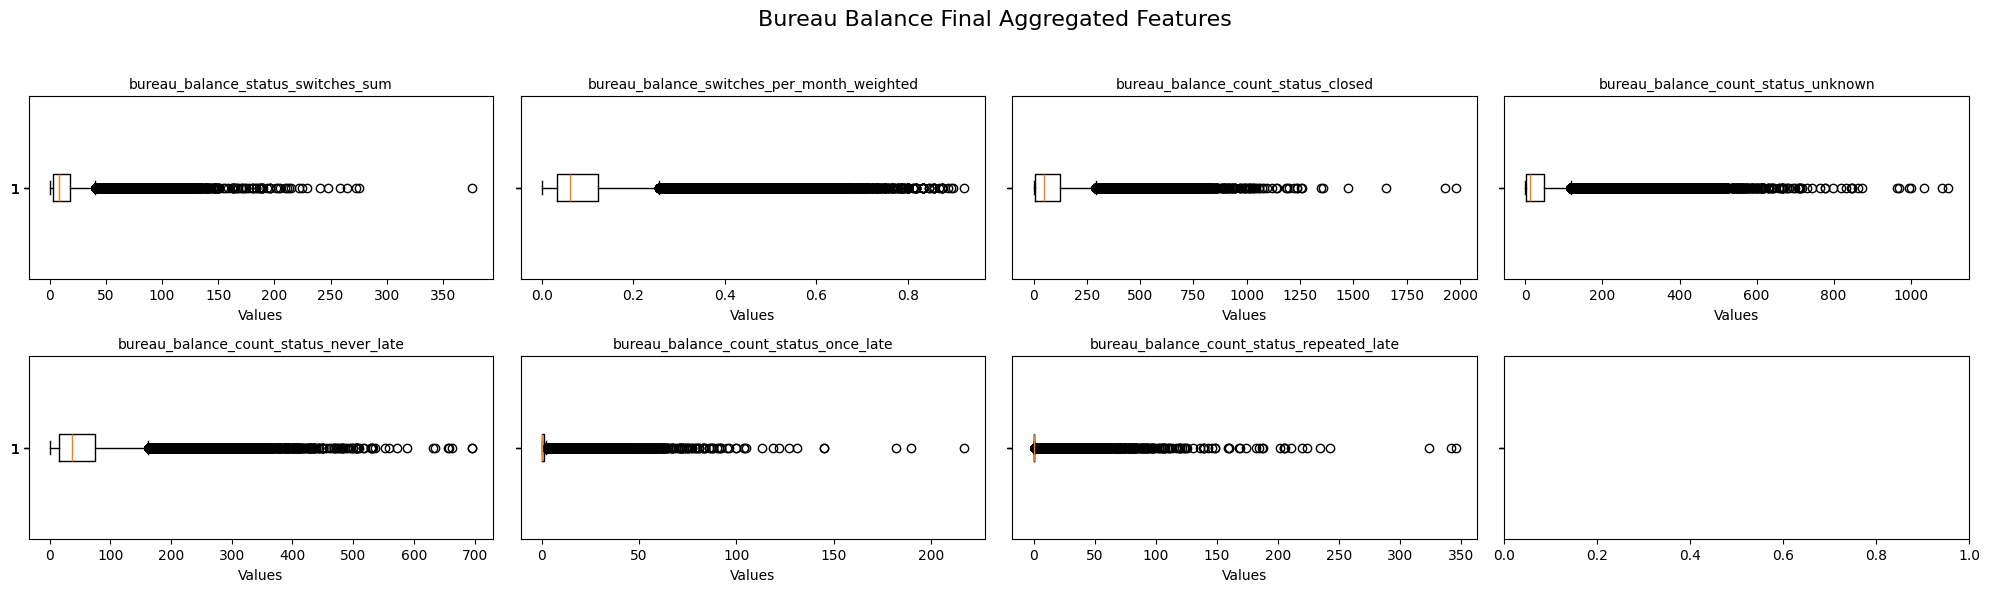

In [56]:
plot_data_cleaned = bureau_balance_final_agg_df.dropna()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6), sharey=True)
fig.suptitle("Bureau Balance Final Aggregated Features", fontsize=16)

columns_to_plot = plot_data_cleaned.drop(columns='SK_ID_CURR').columns

for ax, column in zip(axes.flatten(), columns_to_plot):  # Flatten axes for iteration
    ax.boxplot(plot_data_cleaned[column].dropna().values, vert=False)
    ax.set_title(column, fontsize=10)
    ax.set_xlabel("Values")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Converting all pandas DataFrames to polars and then downcasting their datatypes to save memory.

In [57]:
for idx, frame in enumerate(bureau_frames_to_merge):
    bureau_frames_to_merge[idx] = h.optimize_memory_usage(pl.from_pandas(frame))

Check if all tables have been correctly aggregated.

In [58]:
def check_unique_skidcurr(dataframes):
    """
    Check if the SK_ID_CURR column in each DataFrame contains only unique values.

    Parameters:
        dataframes (list): List of pandas or polars DataFrames to check.

    Returns:
        dict: A dictionary where the keys are the indices of the DataFrames in the list,
              and the values are booleans indicating whether the SK_ID_CURR column has unique values.
    """
    results = {}
    for i, df in enumerate(dataframes):
        if isinstance(df, pd.DataFrame):  # Check for pandas DataFrame
            if 'SK_ID_CURR' in df.columns:
                results[i] = df['SK_ID_CURR'].is_unique
            else:
                results[i] = None
        elif isinstance(df, pl.DataFrame):  # Check for polars DataFrame
            if 'SK_ID_CURR' in df.columns:
                results[i] = df['SK_ID_CURR'].is_unique()
            else:
                results[i] = None
        else:
            results[i] = None  # Unsupported DataFrame type
    return results

In [59]:
def outer_join_keep_one_key(df_left, df_right, join_keys):
    df = df_left.join(df_right, on=join_keys, how="full", suffix="_right")
    for key in join_keys:
        dup_col = f"{key}_right"
        if dup_col in df.columns:
            df = df.drop(dup_col)
    return df

Join the tables while keeping all ids intact.

In [60]:
from functools import reduce

bureau_merged_df = reduce(lambda left, right: outer_join_keep_one_key(left, right, ['SK_ID_CURR']), bureau_frames_to_merge)


Upload the mid-level table to the database.

In [63]:
if "bureau_merged_agg" not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
    con.execute("CREATE TABLE bureau_merged_agg AS SELECT * FROM bureau_merged_df")
else:
    print("Table 'bureau_merged_agg' already exists.")

Table 'bureau_merged_agg' already exists.


#### 2.2.3. POS Cash balance

**Goal**:
- Aggregate by `SK_ID_CURR` for future merging into the highest-level application table
- *Alternative: Aggregate by `SK_ID_PREV` and then merge into the mid-level table* 
    - Only makes sense if we use the mid-level table and its relationships for feature engineering. -> Lack of time to implement this now.
- Get insights into late payment behaviour, the timeline/progress, current status 

Calculating the proportion of payments left at the time of data collection.


If the balance was reported so far back in time that we can assume based on the terms left that the loan was paid off, we will consider the loan probably paid off.




I also created an indicator to see if the balance was reported so far back in time that the total term has already run out at the time of application; than it is considered stale (68% of the records).

In [64]:
pos_frames_to_merge = []

In [65]:
prev_pos_term_prop_df = con.execute(queries.prev_pos_term_prop).fetch_df()
pos_frames_to_merge.append(prev_pos_term_prop_df)
prev_pos_term_prop_df.describe()

,SK_ID_CURR,prev_pos_inst_latest,pos_months_proportion_left,pos_terms_possibly_completed,pos_stale_balance
count,337252.000000,336572.000000,336572.000000,337252.000000,337252.000000
mean,278163.132678,14.868768,0.207036,0.618822,0.367968
std,102877.889290,12.316511,0.305068,0.485677,0.482253
min,100001.000000,1.000000,0.000000,0.000000,0.000000
25%,189046.750000,6.000000,0.000000,0.000000,0.000000
50%,278241.500000,12.000000,0.000000,1.000000,0.000000
75%,367320.250000,18.000000,0.400000,1.000000,1.000000
max,456255.000000,84.000000,1.000000,1.000000,1.000000


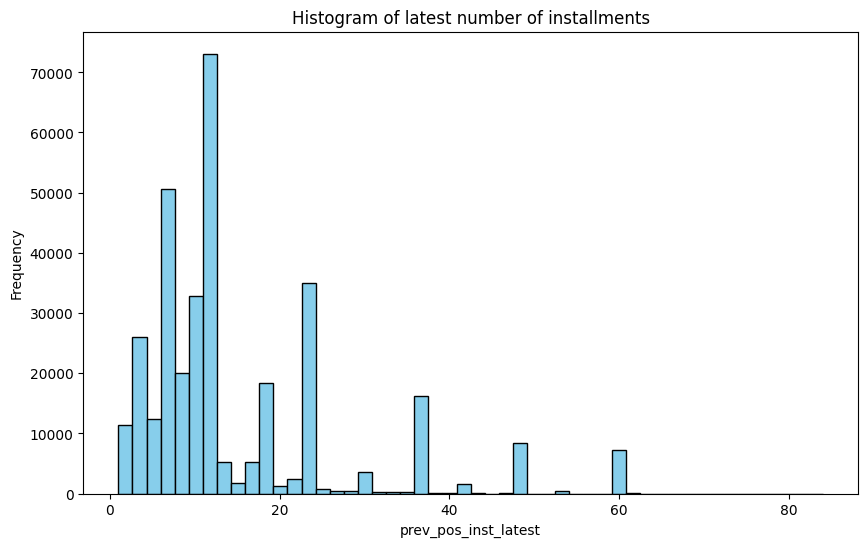

In [66]:
plt.figure(figsize=(10, 6))
plt.hist(prev_pos_term_prop_df['prev_pos_inst_latest'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of latest number of installments')
plt.xlabel('prev_pos_inst_latest')
plt.ylabel('Frequency')
plt.show()

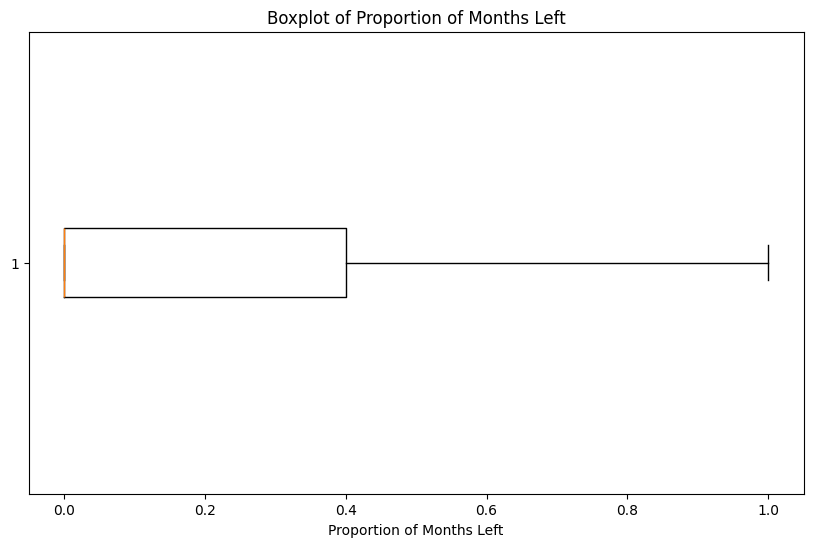

In [67]:
plt.figure(figsize=(10, 6))
plt.boxplot(prev_pos_term_prop_df['pos_months_proportion_left'].dropna(), vert=False)
plt.title('Boxplot of Proportion of Months Left')
plt.xlabel('Proportion of Months Left')
plt.show(   )

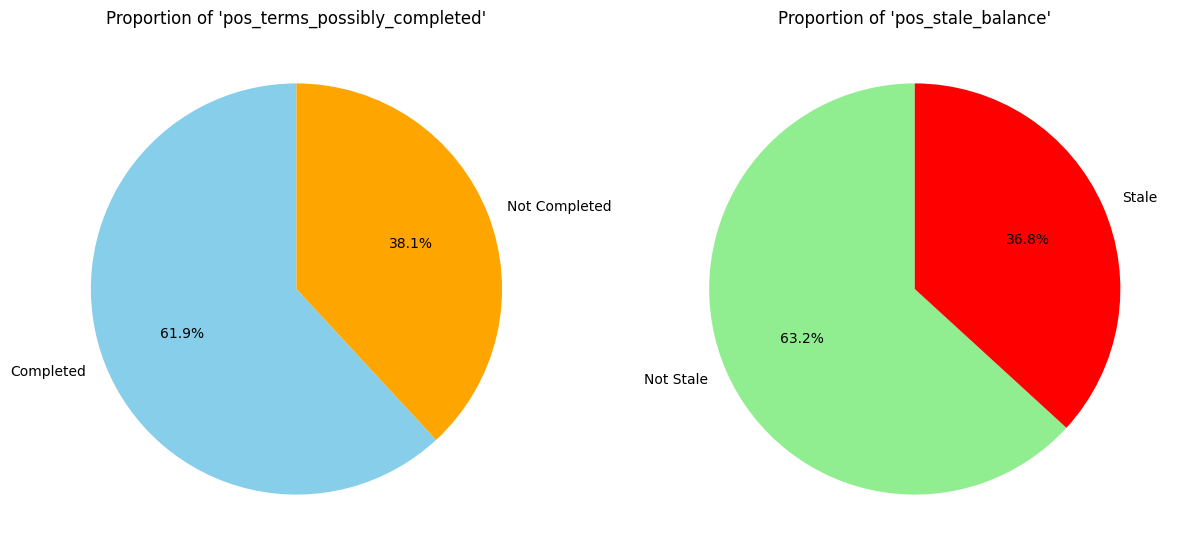

In [68]:
feature_1_proportion = prev_pos_term_prop_df['pos_terms_possibly_completed'].value_counts(normalize=True)
feature_2_proportion = prev_pos_term_prop_df['pos_stale_balance'].value_counts(normalize=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(
    feature_1_proportion, 
    labels=feature_1_proportion.index.map({1: 'Completed', 0: 'Not Completed'}),
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'orange']
)
axs[0].set_title("Proportion of 'pos_terms_possibly_completed'")

axs[1].pie(
    feature_2_proportion, 
    labels=feature_2_proportion.index.map({1: 'Stale', 0: 'Not Stale'}),
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightgreen', 'red']
)
axs[1].set_title("Proportion of 'pos_stale_balance'")

plt.tight_layout()
plt.show()


Query to get the status of the balance at the time of application and frequency encoding it right away.

In [69]:
prev_pos_status_df = con.execute(queries.prev_pos_status_query).fetch_df()
pos_frames_to_merge.append(prev_pos_status_df)
prev_pos_status_df.describe()

,SK_ID_CURR,pos_status_frequency
count,337252.000000,337252.000000
mean,278163.132678,0.441570
std,102877.889290,0.417119
min,100001.000000,0.000001
25%,189046.750000,0.074478
50%,278241.500000,0.074478
75%,367320.250000,0.914988
max,456255.000000,0.914988


Get the Days Past Due tendencies for each application.

In [70]:
prev_pos_avg_dpd_df = con.execute(queries.prev_pos_dpd_query).fetch_df()
pos_frames_to_merge.append(prev_pos_avg_dpd_df) 
prev_pos_avg_dpd_df.describe()

,SK_ID_CURR,prev_pos_avg_dpd,prev_pos_max_dpd,prev_pos_min_dpd,prev_pos_avg_dpd_def,prev_pos_max_dpd_def,prev_pos_min_dpd_def
count,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000
mean,278163.132678,4.296271,15.294106,0.046885,0.225470,1.473355,0.000904
std,102877.889290,59.717229,151.343806,4.641037,13.554576,32.337266,0.375754
min,100001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189046.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278241.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367320.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,2622.078431,4231.000000,882.000000,1740.554455,3595.000000,176.000000


Merge POS tables by `SK_ID_CURR`.

In [71]:
for idx, frame in enumerate(pos_frames_to_merge):
    pos_frames_to_merge[idx] = h.optimize_memory_usage(pl.from_pandas(frame))

In [72]:
pos_merged_df = reduce(lambda left, right: outer_join_keep_one_key(left, right, ['SK_ID_CURR']), pos_frames_to_merge)

Create table in the database for the POS balance table.

In [76]:
if "pos_merged_agg" not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
    con.execute("CREATE TABLE pos_merged_agg AS SELECT * FROM pos_merged_df")
else:
    print("Table 'pos_merged_agg' already exists.")

Table 'pos_merged_agg' already exists.


#### 2.2.4. Installments payments

**Goal**:
- Aggregate by `SK_ID_CURR` for future merging into the highest-level application table
- *Alternative: Aggregate by `SK_ID_PREV` and then merge into the mid-level table* 
    - Only makes sense if we use the mid-level table and its relationships for feature engineering. -> Lack of time to implement this now.
- Get insights into installment plan and its version, expected/actual payment

In [77]:
inst_frames_to_merge = []

##### 2.2.4.1. Queries

In [78]:
prev_inst_version_df = con.execute(queries.prev_inst_version_query).fetch_df()
inst_frames_to_merge.append(prev_inst_version_df)
prev_inst_version_df.describe()

,SK_ID_CURR,prev_schedule_changes,prev_is_credit_card
count,339587.000000,339587.000000,339587.00000
mean,278154.892278,2.130435,0.00894
std,102880.492598,1.912109,0.09413
min,100001.000000,0.000000,0.00000
25%,189042.500000,1.000000,0.00000
50%,278238.000000,2.000000,0.00000
75%,367315.500000,2.000000,0.00000
max,456255.000000,178.000000,1.00000


It's unlikely that someone had 178 versions of their payment plan approved for a single credit, so I will remove the outlier.

In [79]:
prev_inst_version_df['prev_schedule_changes'] = prev_inst_version_df['prev_schedule_changes'].apply(lambda x: np.nan if x > 170 else x)

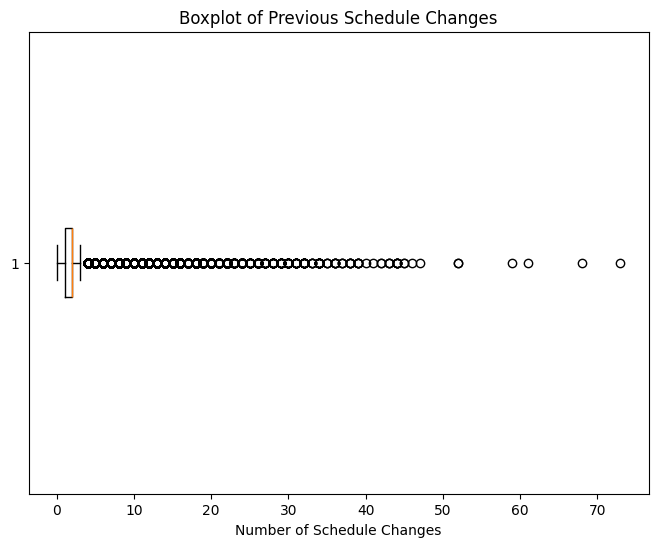

In [80]:
plt.figure(figsize=(8, 6))
plt.boxplot(prev_inst_version_df['prev_schedule_changes'].dropna(), vert=False)
plt.title('Boxplot of Previous Schedule Changes')
plt.xlabel('Number of Schedule Changes')
plt.show()

Checking if the record is a credit card plan or not.

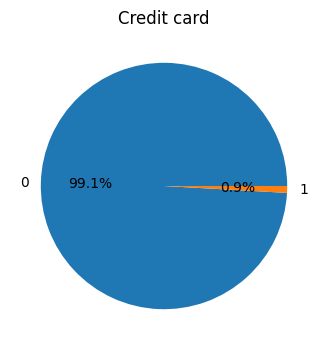

In [81]:
prev_inst_version_df['prev_is_credit_card'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(4, 4)
)
plt.title('Credit card')
plt.ylabel('') 
plt.show()

The graph is logical, as installments are not practical for credit cards.

Insights into payments: delayed, overpaid, paid off, paid in advance

In [82]:
prev_inst_payment_df = con.execute(queries.prev_inst_payment_query).fetch_df()
inst_frames_to_merge.append(prev_inst_payment_df)
prev_inst_payment_df.describe()

,SK_ID_CURR,prev_inst_payment_ratio_avg,prev_inst_underpayment_count,prev_inst_overpayment_count,prev_inst_payment_delay_avg,prev_inst_payment_delayed_count,prev_inst_payment_early_count,prev_inst_overpaid_in_total
count,339587.000000,339575.000000,339587.000000,339587.000000,339578.000000,339587.000000,339587.000000,339587.000000
mean,278154.892278,1.360331,3.814908,0.528280,-11.257628,3.376658,27.414115,0.117893
std,102880.492598,28.429260,7.994107,2.070338,12.976502,6.374030,24.404787,0.322482
min,100001.000000,0.333333,0.000000,0.000000,-295.000000,0.000000,0.000000,0.000000
25%,189042.500000,0.955224,0.000000,0.000000,-14.846154,0.000000,10.000000,0.000000
50%,278238.000000,1.000000,0.000000,0.000000,-9.564103,1.000000,20.000000,0.000000
75%,367315.500000,1.000000,4.000000,0.000000,-5.888889,4.000000,36.000000,0.000000
max,456255.000000,8482.446155,154.000000,66.000000,1884.204545,159.000000,250.000000,1.000000


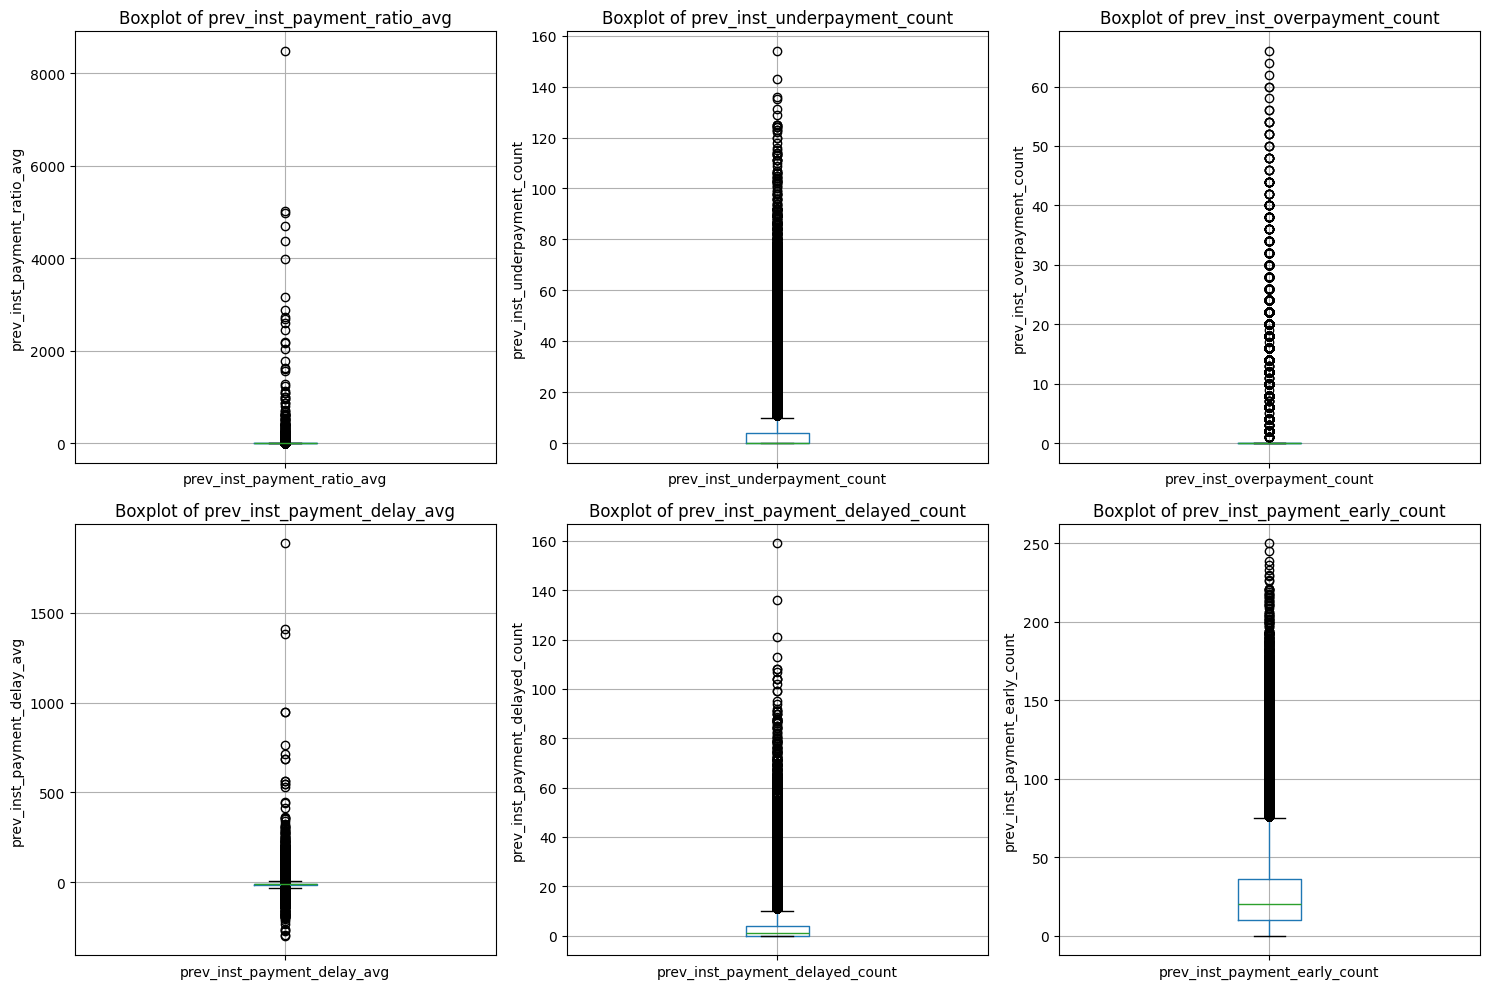

In [ ]:
n_cols = 3
n_rows = -(-len(prev_inst_payment_df.columns[1:-1]) // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, column in enumerate(prev_inst_payment_df.columns[1:-1]):  
    prev_inst_payment_df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

##### 2.2.4.2. Experimental feature creation

Count how many installments have been skipped/not registered based on the plan.

- The feature has high variance, so it might be useful for the model later.

In [84]:
prev_inst_missing_inst_df = con.execute(queries.prev_inst_missing_inst_query).fetch_df()
inst_frames_to_merge.append(prev_inst_missing_inst_df)
prev_inst_missing_inst_df.describe()

,SK_ID_CURR,prev_inst_number_skipped_total
count,339587.000000,339587.000000
mean,278154.892278,19.029188
std,102880.492598,22.321675
min,100001.000000,1.000000
25%,189042.500000,2.000000
50%,278238.000000,11.000000
75%,367315.500000,27.000000
max,456255.000000,260.000000


Count how many times the installments were increased.

- The feature has high variance, so it might be useful for the model later.

In [85]:
prev_inst_rate_increase_df = con.execute(queries.prev_inst_rate_increase_query).fetch_df()
inst_frames_to_merge.append(prev_inst_rate_increase_df)
prev_inst_rate_increase_df.describe()

,SK_ID_CURR,prev_inst_amt_increases_total
count,339587.000000,339587.000000
mean,278154.892278,13.313233
std,102880.492598,16.065781
min,100001.000000,0.000000
25%,189042.500000,1.000000
50%,278238.000000,8.000000
75%,367315.500000,19.000000
max,456255.000000,161.000000


The difference between planned and paid amount multiplied by the number of installments intended as a 'time factor'.

In [86]:
prev_inst_number_df = con.execute(queries.prev_inst_number_query).fetch_df()
inst_frames_to_merge.append(prev_inst_number_df)
prev_inst_number_df.describe()

,SK_ID_CURR,prev_inst_unpaid_time_factor
count,339587.000000,3.395780e+05
mean,278154.892278,1.255115e+03
std,102880.492598,2.861770e+04
min,100001.000000,-1.505018e+06
25%,189042.500000,0.000000e+00
50%,278238.000000,0.000000e+00
75%,367315.500000,3.645731e+03
max,456255.000000,1.406098e+06


Merge the tables by `SK_ID_CURR`.


In [87]:
for idx, frame in enumerate(inst_frames_to_merge):
    inst_frames_to_merge[idx] = h.optimize_memory_usage(pl.from_pandas(frame))

In [88]:
inst_merged_df = reduce(lambda left, right: outer_join_keep_one_key(left, right, ['SK_ID_CURR']), inst_frames_to_merge)

Upload the table to the database.

In [90]:
if "inst_merged_agg" not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
    con.execute("CREATE TABLE inst_merged_agg AS SELECT * FROM inst_merged_df")
else:
    print("Table 'inst_merged_agg' already exists.")

Table 'inst_merged_agg' already exists.


#### 2.2.5. Credit card balance

**Goal**:
- Aggregate by `SK_ID_CURR` for future merging into the highest-level application table
- *Alternative: Aggregate by `SK_ID_PREV` and then merge into the mid-level table* 
    - Only makes sense if we use the mid-level table and its relationships for feature engineering. -> Lack of time to implement this now.
- Get insights on payments, drawings and receivables

> In the context of credit card balance, receivables typically represent the outstanding balances that are yet to be paid by the borrowers.

In [91]:
cred_frames_to_merge = []

Frequency encode latest status and check if it was active.

In [92]:
prev_card_contract_status_df = con.execute(queries.prev_card_contract_status_query).fetch_df()
cred_frames_to_merge.append(prev_card_contract_status_df)
prev_card_contract_status_df.describe()

,SK_ID_CURR,prev_card_status_frequency,prev_card_latest_active_status
count,103558.000000,103558.000000,103558.000000
mean,278381.457956,0.847039,0.875200
std,102779.519683,0.307236,0.330493
min,100006.000000,0.000355,0.000000
25%,189536.250000,0.963056,1.000000
50%,278649.000000,0.963056,1.000000
75%,367690.000000,0.963056,1.000000
max,456250.000000,0.963056,1.000000


Checking balance and payments and the change in them for 3 months and 6 month intervals.

In [93]:
prev_card_ranked_balance_df = con.execute(queries.prev_card_ranked_balance_query).fetch_df()
cred_frames_to_merge.append(prev_card_ranked_balance_df)
prev_card_ranked_balance_df.describe()

,SK_ID_CURR,prev_card_avg_balance_last_3m,prev_card_avg_balance_last_6m,prev_card_balance_change_3m_vs_6m,prev_card_avg_payment_last_3m,prev_card_avg_payment_last_6m,prev_card_payment_change_3m_vs_6m
count,103558.000000,1.035580e+05,1.035580e+05,103558.00000,7.212000e+04,7.212000e+04,7.212000e+04
mean,278381.457956,7.258074e+04,6.961318e+04,2967.55662,1.364823e+04,1.479930e+04,-1.151074e+03
std,102779.519683,1.423330e+05,1.352250e+05,27930.77315,3.514844e+04,3.206558e+04,1.744567e+04
min,100006.000000,0.000000e+00,0.000000e+00,-478859.52000,0.000000e+00,0.000000e+00,-3.375000e+05
25%,189536.250000,0.000000e+00,0.000000e+00,0.00000,9.333000e+01,1.462500e+02,-9.952219e+01
50%,278649.000000,0.000000e+00,0.000000e+00,0.00000,3.887812e+03,5.400000e+03,0.000000e+00
75%,367690.000000,9.438626e+04,9.038941e+04,0.00000,1.383087e+04,1.693076e+04,9.094947e-13
max,456250.000000,1.139087e+06,1.020095e+06,436519.21500,1.786078e+06,1.593111e+06,4.119548e+05


Get insights on utilization.

> Utilization refers to the ratio of the credit balance to the credit limit, indicating how much of the available credit is being used.

In [94]:
prev_card_delinq_patt_df = con.execute(queries.prev_card_delinq_patt_query).fetch_df()
cred_frames_to_merge.append(prev_card_delinq_patt_df)
prev_card_delinq_patt_df.describe()

,SK_ID_CURR,prev_card_avg_utilization,prev_card_stddev_utilization,prev_card_max_utilization
count,102445.000000,102445.000000,101756.000000,102445.000000
mean,278376.580624,0.320573,0.204930,0.622298
std,102785.315068,0.324382,0.177584,0.482908
min,100006.000000,-0.084848,0.000000,0.000000
25%,189509.000000,0.000000,0.000000,0.000000
50%,278660.000000,0.241313,0.220170,0.939516
75%,367656.000000,0.583274,0.368198,1.043610
max,456250.000000,2.138790,1.909228,11.777510


Proportions of drawings by pos, ATM and other.

In [95]:
prev_card_drawings_df = con.execute(queries.prev_card_drawings_query).fetch_df()
cred_frames_to_merge.append(prev_card_drawings_df)
prev_card_drawings_df.describe()

,SK_ID_CURR,prev_card_pct_atm_drawings,prev_card_pct_pos_drawings,prev_card_pct_other_drawings
count,70264.000000,70264.000000,70264.000000,70264.000000
mean,278732.440695,0.625062,0.314523,0.033096
std,102534.940493,0.386486,0.377542,0.149358
min,100011.000000,0.000000,0.000000,0.000000
25%,190556.500000,0.250000,0.000000,0.000000
50%,278777.500000,0.761266,0.093573,0.000000
75%,367760.000000,1.000000,0.644059,0.000000
max,456250.000000,1.000000,1.000000,1.000000


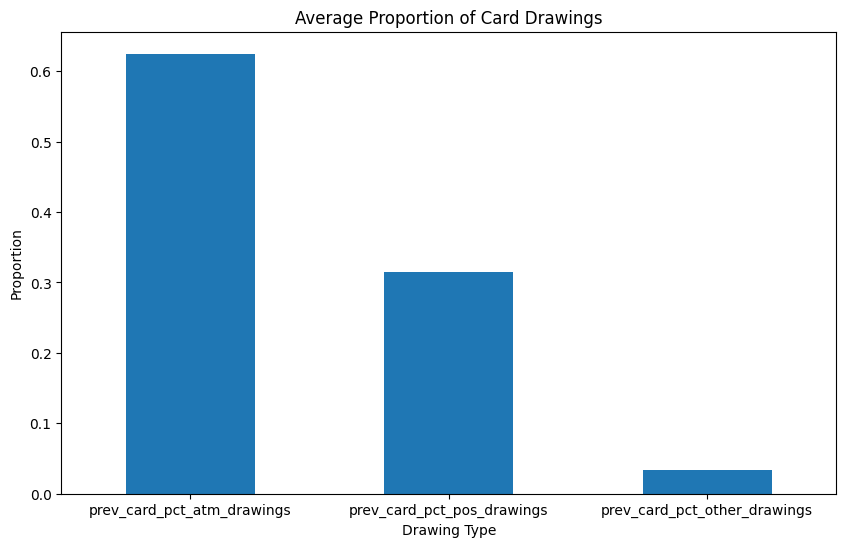

In [96]:
prev_card_drawings_df[['prev_card_pct_atm_drawings', 'prev_card_pct_pos_drawings', 'prev_card_pct_other_drawings']].mean().plot(
    kind='bar', figsize=(10, 6), title='Average Proportion of Card Drawings'
)
plt.ylabel('Proportion')
plt.xlabel('Drawing Type')
plt.xticks(rotation=0)
plt.show()

Aggregated credit card features:

- **Average Metrics**: Interest fees ratio, debt vs. principal, receivable difference, principal reduction rate, non-principal amount.
- **Maximum Metrics**: Interest fees ratio, debt vs. principal, receivable difference, principal reduction rate, non-principal amount.
- **Minimum Metrics**: Interest fees ratio, debt vs. principal, receivable difference, principal reduction rate, non-principal amount.


In [97]:
prev_card_monthly_tendencies_df = con.execute(queries.prev_card_monthly_tendencies_query).fetch_df()
cred_frames_to_merge.append(prev_card_monthly_tendencies_df)
prev_card_monthly_tendencies_df.describe()

,SK_ID_CURR,prev_card_avg_interest_fees_ratio,prev_card_avg_total_debt_vs_principal,prev_card_avg_receivable_difference,prev_card_avg_principal_reduction_rate,prev_card_avg_non_principal_amount,prev_card_max_interest_fees_ratio,prev_card_max_total_debt_vs_principal,prev_card_max_receivable_difference,prev_card_max_principal_reduction_rate,prev_card_max_non_principal_amount,prev_card_min_interest_fees_ratio,prev_card_min_total_debt_vs_principal,prev_card_min_receivable_difference,prev_card_min_principal_reduction_rate,prev_card_min_non_principal_amount
count,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,69384.000000,6.938400e+04,69384.000000
mean,278655.273233,0.407594,1.407594,13.081423,-11.502405,4821.433877,3.473458,4.473458,88.451289,0.363296,9593.524002,0.015328,1.015328,3.066885,-1.692628e+02,1123.705854
std,102565.319357,28.068889,28.068889,278.448086,1016.408881,4218.530151,250.022424,250.022424,602.722153,0.345334,7988.401519,0.557036,0.557036,132.804342,1.011830e+04,2530.806709
min,100011.000000,-1.452784,-0.452784,0.000000,-207990.664338,-7690.845000,0.000000,1.000000,0.000000,0.000000,0.000000,-10.938728,-9.938728,0.000000,-1.331666e+06,-297116.685000
25%,190348.750000,0.023151,1.023151,0.000000,-0.301479,2083.680121,0.040245,1.040245,0.000000,0.050228,4101.221250,0.000000,1.000000,0.000000,-3.109407e+00,0.000000
50%,278808.500000,0.035838,1.035838,0.000000,-0.061412,3930.234643,0.064494,1.064494,0.000000,0.229271,7842.645000,0.008986,1.008986,0.000000,-9.926938e-01,426.105000
75%,367728.500000,0.050294,1.050294,0.000000,0.002334,6308.396404,0.120983,1.120983,0.000000,0.671199,13048.413750,0.026530,1.026530,0.000000,-1.878458e-01,1863.911250
max,456250.000000,3883.050392,3884.050392,34552.500000,0.628507,182605.695674,38830.000000,38831.000000,40950.000000,1.000000,231684.210000,142.309645,143.309645,17010.000000,0.000000e+00,21861.360000


Monthly changes in above metrics.

In [98]:
prev_card_monthly_changes_df = con.execute(query=queries.prev_card_monthly_changes_query).fetch_df()
cred_frames_to_merge.append(prev_card_monthly_changes_df)
prev_card_monthly_changes_df.describe()

,SK_ID_CURR,prev_card_avg_drawings_change,prev_card_avg_payment_change,prev_card_avg_principal_change,prev_card_avg_cnt_drawings_change,prev_card_avg_payment_coverage_change,prev_card_avg_total_payment_coverage_change,prev_card_avg_atm_drawings_percentage_change,prev_card_avg_pos_drawings_percentage_change,prev_card_avg_other_drawings_percentage_change,prev_card_max_drawings_change,prev_card_min_drawings_change,prev_card_max_payment_change,prev_card_min_payment_change
count,103558.000000,103558.000000,71696.000000,103558.000000,103558.000000,69440.000000,69466.000000,69903.000000,69903.000000,69903.000000,1.035580e+05,1.035580e+05,7.169600e+04,7.169600e+04
mean,278381.457956,-1481.477126,-1009.707496,3235.415289,-0.015897,1.072835,1.126235,0.711513,0.572245,-0.012076,7.047566e+04,-8.626232e+04,9.916533e+04,-1.084330e+05
std,102779.519683,8894.812911,11339.509003,10510.960209,0.714624,2461.023691,2357.866709,86.552812,23.045109,0.482049,1.027089e+05,1.103844e+05,1.383864e+05,1.441577e+05
min,100006.000000,-450000.000000,-652500.000000,-188250.000000,-22.000000,-595143.521725,-565386.148069,-25.570196,-1.000000,-1.000000,0.000000e+00,-2.287098e+06,-6.525000e+05,-2.951617e+06
25%,189536.250000,-750.000000,-450.000000,0.000000,-0.020833,-0.309202,-0.281266,-0.543504,-0.048223,0.000000,0.000000e+00,-1.342766e+05,1.125000e+04,-1.451234e+05
50%,278649.000000,0.000000,0.000000,0.000000,0.000000,-0.045087,-0.027119,-0.166667,0.000000,0.000000,3.468406e+04,-5.850000e+04,4.500000e+04,-5.400000e+04
75%,367690.000000,0.000000,90.000000,1966.806562,0.000000,0.142827,0.124145,0.000000,0.006720,0.000000,1.076767e+05,0.000000e+00,1.350000e+05,-1.439628e+04
max,456250.000000,452250.000000,379881.000000,327847.950000,36.000000,209919.878392,209990.568061,19756.838906,3486.992638,69.628011,2.287098e+06,0.000000e+00,3.417462e+06,3.798810e+05


Aggregated drawings characteristics.

In [99]:
prev_card_avg_drawings_df = con.execute(queries.prev_card_avg_drawings_query).fetch_df()
cred_frames_to_merge.append(prev_card_avg_drawings_df)
prev_card_avg_drawings_df.describe()

,SK_ID_CURR,prev_card_min_drawings_atm,prev_card_max_drawings_atm,prev_card_avg_drawings_atm,prev_card_min_drawings_pos,prev_card_max_drawings_pos,prev_card_avg_drawings_pos,prev_card_min_drawings_other,prev_card_max_drawings_other,prev_card_avg_drawings_other
count,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000
mean,278381.457956,76.881080,25669.622901,3123.278744,49.161934,11153.560810,1314.480112,2.044072,5842.479546,315.233234
std,102779.519683,1776.579591,34431.933393,5994.705724,1627.005320,32849.873801,4892.923164,448.600819,35956.653448,2793.027754
min,100006.000000,-6827.310000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189536.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278649.000000,0.000000,16875.000000,571.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367690.000000,0.000000,40500.000000,3750.000000,0.000000,6732.436103,963.253080,0.000000,0.000000,0.000000
max,456250.000000,157500.000000,677250.000000,157500.000000,337500.000000,900000.000000,360000.000000,112500.000000,899910.000000,134872.302857


Days Past Due tendencies.

In [100]:
prev_card_dpd_df = con.execute(queries.prev_card_dpd_query).fetch_df()
cred_frames_to_merge.append(prev_card_dpd_df)
prev_card_dpd_df.describe()

,SK_ID_CURR,prev_card_max_dpd,prev_card_max_dpd_def,prev_card_avg_dpd,prev_card_avg_dpd_def,prev_card_count_dpd,prev_card_count_dpd_def,prev_card_delinquency_rate,prev_card_delinquency_severity,prev_card_recent_dpd
count,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,17029.000000,20660.0
mean,278381.457956,16.401871,0.812424,4.107206,0.151713,1.480861,0.862705,0.020027,0.898172,-62.702227
std,102779.519683,141.966150,26.177042,44.341025,11.105665,6.122852,3.312967,0.076482,0.290027,28.035811
min,100006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000738,-96.0
25%,189536.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-86.0
50%,278649.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-70.0
75%,367690.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-45.0
max,456250.000000,3260.000000,3260.000000,1635.684783,1635.684783,94.000000,94.000000,1.000000,1.878049,-1.0


Merge the tables by `SK_ID_CURR`.

In [101]:
for idx, frame in enumerate(cred_frames_to_merge):
    cred_frames_to_merge[idx] = h.optimize_memory_usage(pl.from_pandas(frame))

In [102]:
card_merged_df = reduce(lambda left, right: outer_join_keep_one_key(left, right, ['SK_ID_CURR']), cred_frames_to_merge)

In [192]:
if "card_merged_agg" not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
    con.execute("CREATE TABLE card_merged_agg AS SELECT * FROM card_merged_df")
else:
    print("Table 'card_merged_agg' already exists.")

Table 'card_merged_agg' already exists.


#### 2.2.6. Previous applications

**Goal**:
- Aggregate by `SK_ID_CURR` for future merging into the highest-level application table

**Note:** 

- This is a mid-level table, which could house relationships with lower-level tables, but I will not implement this now due to time constraints.
- In this case I included all the logic into the query

`NFLAG_MICRO_CASH` is present in the documentation, but not in the dataset, so I do not query it.

In [ ]:
prev_app_features = [
    "SK_ID_PREV",
    "SK_ID_CURR",
    "NAME_CONTRACT_TYPE",
    "AMT_ANNUITY",
    "AMT_APPLICATION",
    "AMT_CREDIT",
    "AMT_DOWN_PAYMENT",
    "AMT_GOODS_PRICE",
    "WEEKDAY_APPR_PROCESS_START",
    "HOUR_APPR_PROCESS_START",
    "FLAG_LAST_APPL_PER_CONTRACT",
    "NFLAG_LAST_APPL_IN_DAY",
    "RATE_DOWN_PAYMENT",
    "RATE_INTEREST_PRIMARY",
    "RATE_INTEREST_PRIVILEGED",
    "NAME_CASH_LOAN_PURPOSE",
    "NAME_CONTRACT_STATUS",
    "DAYS_DECISION",
    "NAME_PAYMENT_TYPE",
    "CODE_REJECT_REASON",
    "NAME_TYPE_SUITE",
    "NAME_CLIENT_TYPE",
    "NAME_GOODS_CATEGORY",
    "NAME_PORTFOLIO",
    "NAME_PRODUCT_TYPE",
    "CHANNEL_TYPE",
    "SELLERPLACE_AREA",
    "NAME_SELLER_INDUSTRY",
    "CNT_PAYMENT",
    "NAME_YIELD_GROUP",
    "PRODUCT_COMBINATION",
    "DAYS_FIRST_DRAWING",
    "DAYS_FIRST_DUE",
    "DAYS_LAST_DUE_1ST_VERSION",
    "DAYS_LAST_DUE",
    "DAYS_TERMINATION",
    "NFLAG_INSURED_ON_APPROVAL"
]


In [104]:
prev_app_to_merge = []

In [105]:
prev_app = con.execute('SELECT * FROM previous_application').fetch_df()

In [106]:
prev_app.shape

(1670214, 37)

In [107]:
prev_app_missing = h.calculate_missing_proportion(prev_app)

In [108]:
prev_app_missing = prev_app_missing.round(4)
prev_app_missing

SK_ID_PREV                     0.0000
SK_ID_CURR                     0.0000
NAME_CONTRACT_TYPE             0.0000
AMT_ANNUITY                    0.2229
AMT_APPLICATION                0.0000
AMT_CREDIT                     0.0000
AMT_DOWN_PAYMENT               0.5364
AMT_GOODS_PRICE                0.2308
WEEKDAY_APPR_PROCESS_START     0.0000
HOUR_APPR_PROCESS_START        0.0000
FLAG_LAST_APPL_PER_CONTRACT    0.0000
NFLAG_LAST_APPL_IN_DAY         0.0000
RATE_DOWN_PAYMENT              0.5364
RATE_INTEREST_PRIMARY          0.9964
RATE_INTEREST_PRIVILEGED       0.9964
NAME_CASH_LOAN_PURPOSE         0.0000
NAME_CONTRACT_STATUS           0.0000
DAYS_DECISION                  0.0000
NAME_PAYMENT_TYPE              0.0000
CODE_REJECT_REASON             0.0000
NAME_TYPE_SUITE                0.4912
NAME_CLIENT_TYPE               0.0000
NAME_GOODS_CATEGORY            0.0000
NAME_PORTFOLIO                 0.0000
NAME_PRODUCT_TYPE              0.0000
CHANNEL_TYPE                   0.0000
SELLERPLACE_

In [109]:
features_to_drop = prev_app_missing[prev_app_missing > 0.4].index.tolist()
prev_app.drop(columns=features_to_drop, inplace=True)

In [110]:
prev_app.dtypes

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE                    object
SELLERPLACE_AREA                 int64
NAME_SELLER_INDUSTRY            object
CNT_PAYMENT                    float64
NAME_YIELD_GROUP                object
PRODUCT_COMBINATION      

In [111]:
unique_ids_prev = prev_app['SK_ID_CURR'].nunique()

Based on the competition on Kaggle: [author notes](https://www.kaggle.com/c/home-credit-default-risk/discussion/57248#332035)

I rerplaced indicated XNA, XAP and 365243 with nan, as they are other representations of missing values.

In [112]:
prev_app.replace({'XNA': np.nan, 'XAP': np.nan, 365243: np.nan}, inplace=True)

In [113]:
prev_app_prev_sum = pd.DataFrame(prev_app['SK_ID_CURR'].unique(), columns=['SK_ID_CURR'])

In [114]:
prev_app_prev_sum['prev_app_prev_apps_sum'] = prev_app.groupby('SK_ID_CURR')['SK_ID_PREV'].transform('nunique')

In [115]:
prev_app_to_merge.append(prev_app_prev_sum)
prev_app_prev_sum

,SK_ID_CURR,prev_app_prev_apps_sum
0,271877.0,3.0
1,108129.0,6.0
2,122040.0,4.0
3,176158.0,23.0
4,202054.0,25.0
...,...,...
338852,239799.0,12.0
338853,174832.0,18.0
338854,253940.0,9.0
338855,353284.0,3.0


In [116]:
prev_app.drop(columns=['SK_ID_PREV'], inplace=True)

In [117]:
prev_cat_card_df = prev_app[prev_app.columns[prev_app.dtypes == 'object']].nunique()

In [118]:
prev_cat_card_df[prev_cat_card_df <= 5].index.tolist()

['NAME_CONTRACT_TYPE',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'NAME_CLIENT_TYPE',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'NAME_YIELD_GROUP']

Formerly output dtypes and based on the cardinality I created groups for one_hot encoding below 5, and frequency encoding above 5.

In [119]:
freq_prev = [
    'WEEKDAY_APPR_PROCESS_START',
    'NAME_CASH_LOAN_PURPOSE',
    'CODE_REJECT_REASON',
    'NAME_GOODS_CATEGORY',
    'CHANNEL_TYPE',
    'NAME_SELLER_INDUSTRY',
    'PRODUCT_COMBINATION'
]

one_hot_prev = [
    'NAME_CONTRACT_TYPE',
    'FLAG_LAST_APPL_PER_CONTRACT',
    'NAME_CONTRACT_STATUS',
    'NAME_PAYMENT_TYPE',
    'NAME_CLIENT_TYPE',
    'NAME_PORTFOLIO',
    'NAME_PRODUCT_TYPE',
    'NAME_YIELD_GROUP'
]

num_columns = prev_app.drop(columns='SK_ID_CURR').select_dtypes(include=[np.number]).columns.tolist()

In [120]:
prev_app.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,271877.0,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,1,...,Repeater,Mobile,POS,NaN,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,108129.0,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,1,...,Repeater,NaN,Cash,x-sell,Contact center,-1,NaN,36.0,low_action,Cash X-Sell: low
2,122040.0,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,1,...,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,high,Cash X-Sell: high
3,176158.0,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,1,...,Repeater,NaN,Cash,x-sell,Credit and cash offices,-1,NaN,12.0,middle,Cash X-Sell: middle
4,202054.0,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,1,...,Repeater,NaN,Cash,walk-in,Credit and cash offices,-1,NaN,24.0,high,Cash Street: high


In [121]:
prev_app_aggregated = prev_app.groupby('SK_ID_CURR')[num_columns].agg(['mean', 'min', 'max', 'sum', 'std']).reset_index()

new_feature_names = ['prev_app_' + '_'.join(col).strip() for col in prev_app_aggregated.columns.ravel()]
prev_app_aggregated.columns = new_feature_names

In [122]:
prev_app_aggregated.rename(columns={'prev_app_SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)

In [123]:
prev_app_aggregated.shape

(338856, 46)

In [124]:
prev_app_to_merge.append(
    prev_app_aggregated
)

In [125]:
prev_app_freq = prev_app[['SK_ID_CURR'] + freq_prev]

In [126]:
prev_app_freq.head()

,SK_ID_CURR,WEEKDAY_APPR_PROCESS_START,NAME_CASH_LOAN_PURPOSE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,PRODUCT_COMBINATION
0,271877.0,SATURDAY,NaN,NaN,Mobile,Country-wide,Connectivity,POS mobile with interest
1,108129.0,THURSDAY,NaN,NaN,NaN,Contact center,NaN,Cash X-Sell: low
2,122040.0,TUESDAY,NaN,NaN,NaN,Credit and cash offices,NaN,Cash X-Sell: high
3,176158.0,MONDAY,NaN,NaN,NaN,Credit and cash offices,NaN,Cash X-Sell: middle
4,202054.0,THURSDAY,Repairs,HC,NaN,Credit and cash offices,NaN,Cash Street: high


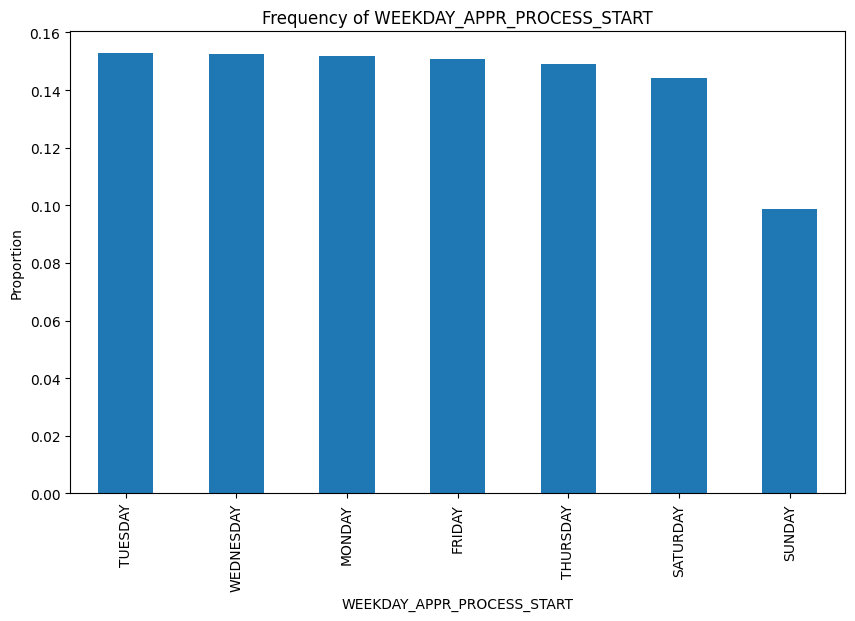

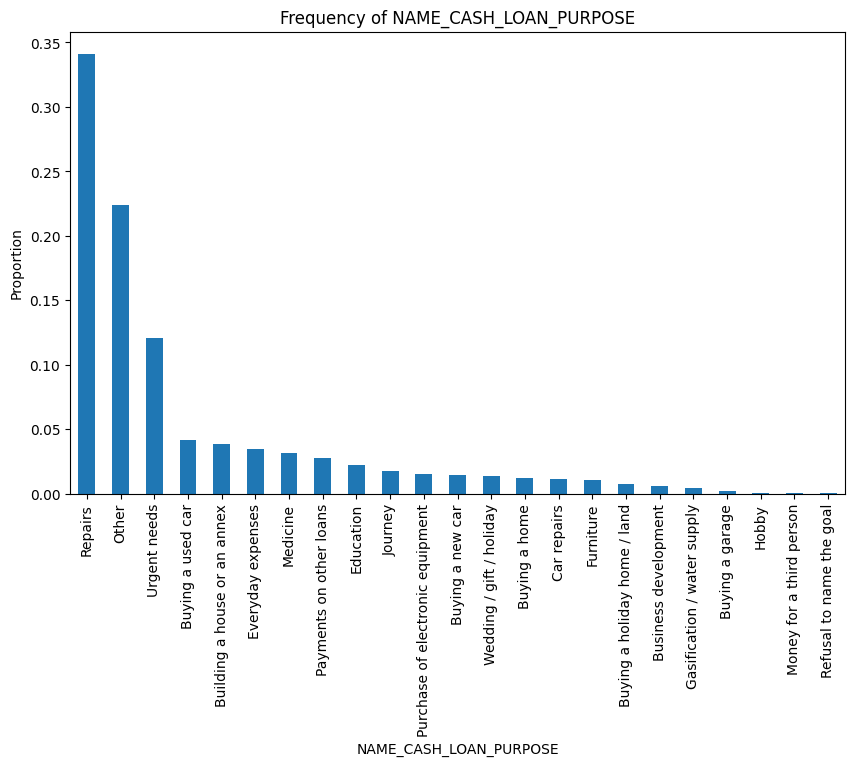

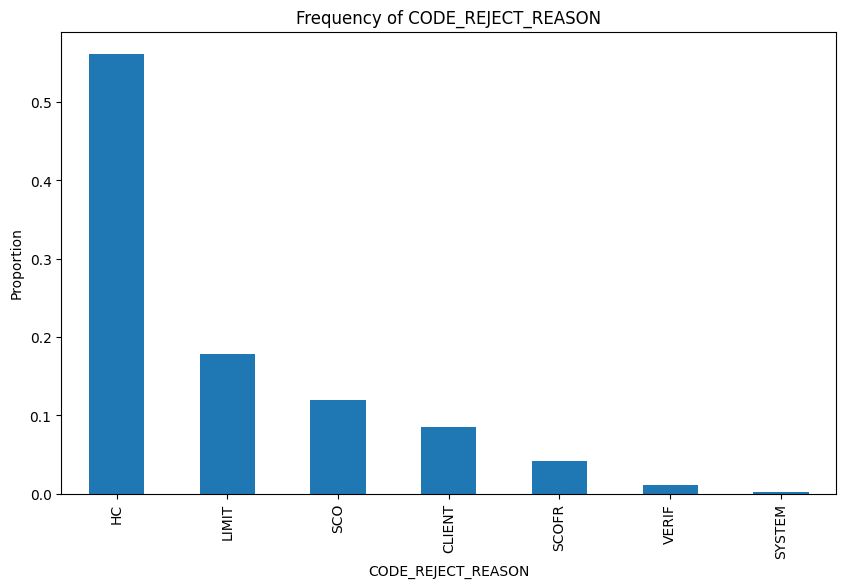

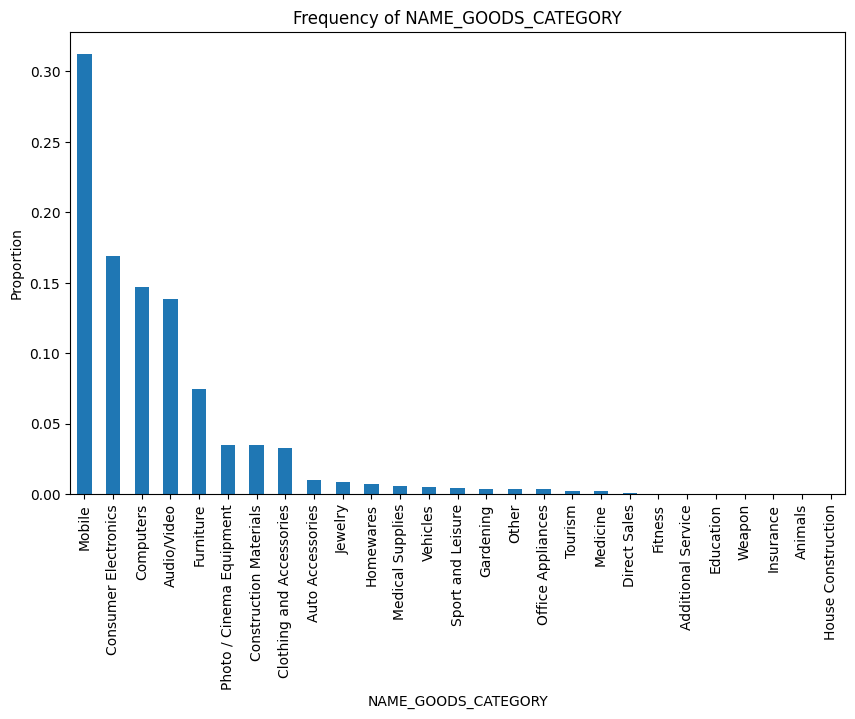

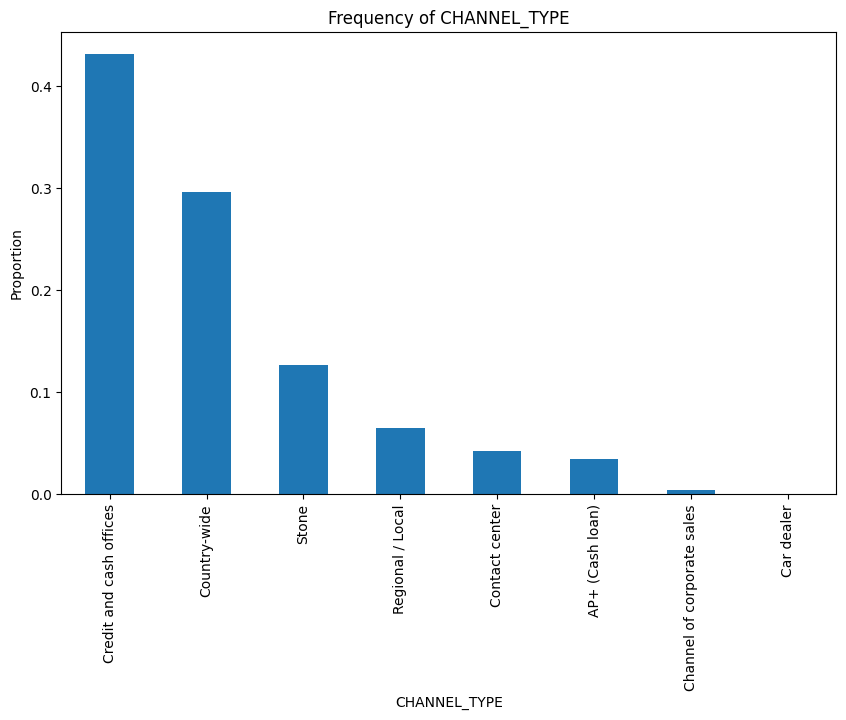

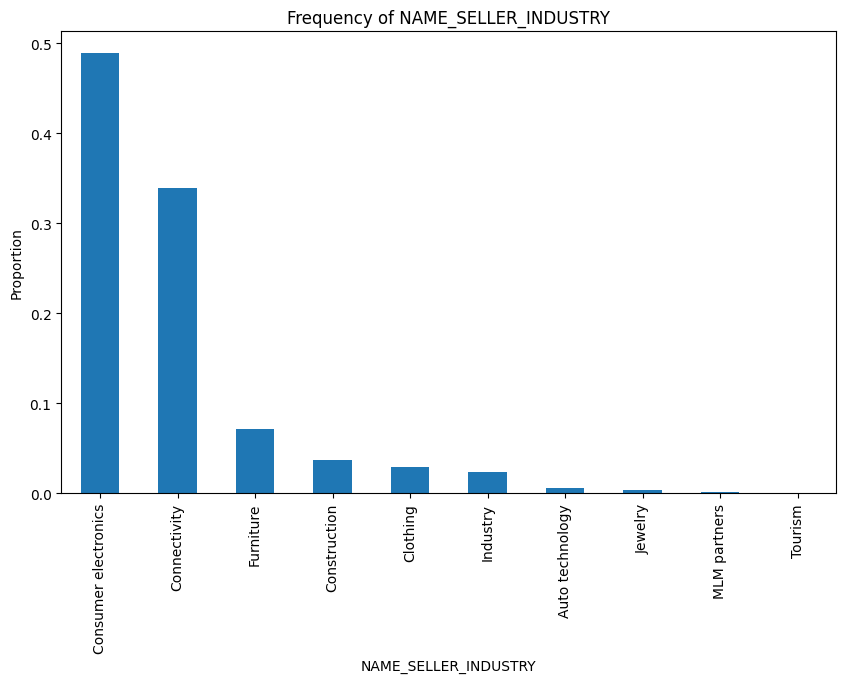

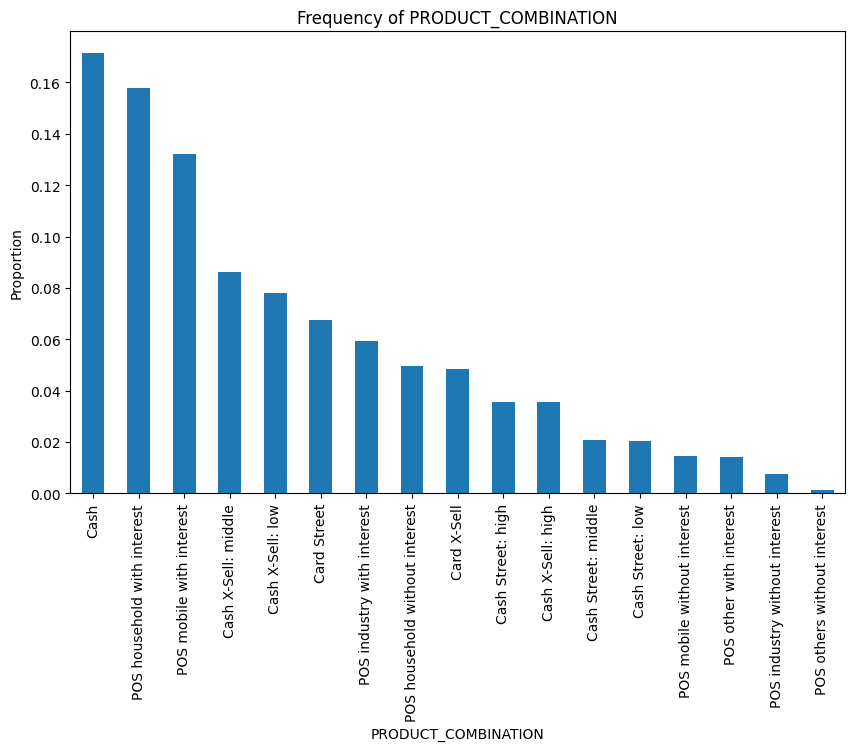

In [127]:
for feature in freq_prev:
    freq_counts = prev_app_freq[feature].value_counts(normalize=True)
    freq_counts.plot(kind='bar', figsize=(10, 6), title=f'Frequency of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Proportion')
    plt.show()

In [128]:
def get_mode(series):
    if series.dropna().empty:
        return None
    mode_series = series.value_counts(dropna=True)
    return mode_series.index[0]

In [129]:
prev_app_freq_query = f"""
WITH mode_table AS (
    { "\nUNION ALL\n".join([
        f"""
        (
        WITH value_counts AS (
            SELECT SK_ID_CURR, 
                   CASE 
                       WHEN {col} IN ('XAP', 'XNA') THEN NULL 
                       ELSE {col} 
                   END AS {col}_cleaned,
                   COUNT(*) AS freq
            FROM previous_application
            GROUP BY SK_ID_CURR, {col}_cleaned
        ),
        ranked AS (
            SELECT *,
                   ROW_NUMBER() OVER (PARTITION BY SK_ID_CURR ORDER BY freq DESC) AS rn
            FROM value_counts
        )
        SELECT
            SK_ID_CURR,
            '{col}' AS feature,
            {col}_cleaned AS mode_value
        FROM ranked
        WHERE rn = 1
        )
        """ for col in freq_prev
    ]) }
)

SELECT
    SK_ID_CURR,
    { ",\n".join([
        f"MAX(CASE WHEN feature = '{col}' THEN mode_value END) AS {col}"
        for col in freq_prev
    ]) }
FROM mode_table
GROUP BY SK_ID_CURR
ORDER BY SK_ID_CURR
"""


In [130]:
prev_app_modes_df = con.execute(prev_app_freq_query).fetch_df()

In [131]:
prev_app_modes_df

,SK_ID_CURR,WEEKDAY_APPR_PROCESS_START,NAME_CASH_LOAN_PURPOSE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,PRODUCT_COMBINATION
0,100001,FRIDAY,None,None,Mobile,Country-wide,Connectivity,POS mobile with interest
1,100002,SATURDAY,None,None,Vehicles,Stone,Auto technology,POS other with interest
2,100003,FRIDAY,None,None,Consumer Electronics,Credit and cash offices,None,POS household with interest
3,100004,FRIDAY,None,None,Mobile,Regional / Local,Connectivity,POS mobile without interest
4,100005,THURSDAY,None,None,Mobile,Credit and cash offices,None,POS mobile with interest
...,...,...,...,...,...,...,...,...
338852,456251,THURSDAY,None,None,Mobile,Country-wide,Connectivity,POS mobile with interest
338853,456252,WEDNESDAY,None,None,Consumer Electronics,Country-wide,Consumer electronics,POS household without interest
338854,456253,TUESDAY,None,None,Mobile,Stone,Connectivity,POS mobile with interest
338855,456254,SATURDAY,None,None,Computers,Country-wide,Connectivity,POS household with interest


In [132]:
for col in prev_app_modes_df[freq_prev].columns:
    prev_app_modes_df[col] = prev_app_modes_df[col].fillna('Unknown')
    
    freq_encoding = prev_app_modes_df[col].value_counts(normalize=True)
    
    prev_app_modes_df[col] = prev_app_modes_df[col].map(freq_encoding)

In [133]:
prev_app_modes_df

,SK_ID_CURR,WEEKDAY_APPR_PROCESS_START,NAME_CASH_LOAN_PURPOSE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,PRODUCT_COMBINATION
0,100001,0.148148,0.985764,0.948264,0.154995,0.360724,0.184278,0.176110
1,100002,0.154316,0.985764,0.948264,0.002370,0.148482,0.003671,0.018450
2,100003,0.148148,0.985764,0.948264,0.076637,0.361105,0.443919,0.215097
3,100004,0.148148,0.985764,0.948264,0.154995,0.074081,0.184278,0.017910
4,100005,0.145970,0.985764,0.948264,0.154995,0.361105,0.443919,0.176110
...,...,...,...,...,...,...,...,...
338852,456251,0.145970,0.985764,0.948264,0.154995,0.360724,0.184278,0.176110
338853,456252,0.149780,0.985764,0.948264,0.076637,0.360724,0.277630,0.058647
338854,456253,0.148703,0.985764,0.948264,0.154995,0.148482,0.184278,0.176110
338855,456254,0.154316,0.985764,0.948264,0.068082,0.360724,0.184278,0.215097


In [134]:
new_feature_names = ['prev_app_' + col for col in prev_app_modes_df.columns[1:] + '_freq']
prev_app_modes_df.columns = ['SK_ID_CURR'] + new_feature_names
prev_app_modes_df.head()

,SK_ID_CURR,prev_app_WEEKDAY_APPR_PROCESS_START_freq,prev_app_NAME_CASH_LOAN_PURPOSE_freq,prev_app_CODE_REJECT_REASON_freq,prev_app_NAME_GOODS_CATEGORY_freq,prev_app_CHANNEL_TYPE_freq,prev_app_NAME_SELLER_INDUSTRY_freq,prev_app_PRODUCT_COMBINATION_freq
0,100001,0.148148,0.985764,0.948264,0.154995,0.360724,0.184278,0.176110
1,100002,0.154316,0.985764,0.948264,0.002370,0.148482,0.003671,0.018450
2,100003,0.148148,0.985764,0.948264,0.076637,0.361105,0.443919,0.215097
3,100004,0.148148,0.985764,0.948264,0.154995,0.074081,0.184278,0.017910
4,100005,0.145970,0.985764,0.948264,0.154995,0.361105,0.443919,0.176110


In [135]:
prev_app_modes_df['SK_ID_CURR'].nunique() / prev_app_modes_df['SK_ID_CURR'].shape[0] 

1.0

In [136]:
prev_app_to_merge.append(prev_app_modes_df)

Did one-hot encoding for categorical variables with low cardinality and frequency encoding for those with high cardinality.

I also decidd to aggregate by client, so I summed up the occurences of the one-hot encoded variables.

In [137]:
prev_app_one_hot_encoded = pd.get_dummies(prev_app[one_hot_prev], prefix=one_hot_prev, drop_first=True)

In [138]:
prev_app_one_hot_encoded['SK_ID_CURR'] = prev_app['SK_ID_CURR']

In [ ]:
prev_app_one_hot_encoded = prev_app_one_hot_encoded.groupby('SK_ID_CURR').sum().reset_index()
prev_app_one_hot_encoded.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,100001.0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,100002.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,100003.0,2,0,3,0,0,0,0,0,2,1,0,1,2,1,0,1,2
3,100004.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,100005.0,1,0,2,1,0,0,0,0,0,1,0,0,1,0,0,0,0


In [140]:
prev_app_one_hot_encoded['SK_ID_CURR'].nunique() / prev_app_one_hot_encoded['SK_ID_CURR'].shape[0] 

1.0

In [141]:
prev_app_to_merge.append(prev_app_one_hot_encoded)

In [143]:
for idx, df in enumerate(prev_app_to_merge):
    prev_app_to_merge[idx] = h.optimize_memory_usage(pl.from_pandas(df))


In [144]:
for idx, df in enumerate(prev_app_to_merge):
    prev_app_to_merge[idx] = prev_app_to_merge[idx].with_columns(pl.col("SK_ID_CURR").cast(pl.Int32))


In [145]:
prev_app_merged = reduce(lambda left, right: outer_join_keep_one_key(left, right, ['SK_ID_CURR']), prev_app_to_merge)

Upload the table to the database.

In [146]:
prev_app_merged

SK_ID_CURR,prev_app_prev_apps_sum,prev_app_AMT_ANNUITY_mean,prev_app_AMT_ANNUITY_min,prev_app_AMT_ANNUITY_max,prev_app_AMT_ANNUITY_sum,prev_app_AMT_ANNUITY_std,prev_app_AMT_APPLICATION_mean,prev_app_AMT_APPLICATION_min,prev_app_AMT_APPLICATION_max,prev_app_AMT_APPLICATION_sum,prev_app_AMT_APPLICATION_std,prev_app_AMT_CREDIT_mean,prev_app_AMT_CREDIT_min,prev_app_AMT_CREDIT_max,prev_app_AMT_CREDIT_sum,prev_app_AMT_CREDIT_std,prev_app_AMT_GOODS_PRICE_mean,prev_app_AMT_GOODS_PRICE_min,prev_app_AMT_GOODS_PRICE_max,prev_app_AMT_GOODS_PRICE_sum,prev_app_AMT_GOODS_PRICE_std,prev_app_HOUR_APPR_PROCESS_START_mean,prev_app_HOUR_APPR_PROCESS_START_min,prev_app_HOUR_APPR_PROCESS_START_max,prev_app_HOUR_APPR_PROCESS_START_sum,prev_app_HOUR_APPR_PROCESS_START_std,prev_app_NFLAG_LAST_APPL_IN_DAY_mean,prev_app_NFLAG_LAST_APPL_IN_DAY_min,prev_app_NFLAG_LAST_APPL_IN_DAY_max,prev_app_NFLAG_LAST_APPL_IN_DAY_sum,prev_app_NFLAG_LAST_APPL_IN_DAY_std,prev_app_DAYS_DECISION_mean,prev_app_DAYS_DECISION_min,prev_app_DAYS_DECISION_max,prev_app_DAYS_DECISION_sum,prev_app_DAYS_DECISION_std,prev_app_SELLERPLACE_AREA_mean,prev_app_SELLERPLACE_AREA_min,prev_app_SELLERPLACE_AREA_max,prev_app_SELLERPLACE_AREA_sum,prev_app_SELLERPLACE_AREA_std,prev_app_CNT_PAYMENT_mean,prev_app_CNT_PAYMENT_min,prev_app_CNT_PAYMENT_max,prev_app_CNT_PAYMENT_sum,prev_app_CNT_PAYMENT_std,prev_app_WEEKDAY_APPR_PROCESS_START_freq,prev_app_NAME_CASH_LOAN_PURPOSE_freq,prev_app_CODE_REJECT_REASON_freq,prev_app_NAME_GOODS_CATEGORY_freq,prev_app_CHANNEL_TYPE_freq,prev_app_NAME_SELLER_INDUSTRY_freq,prev_app_PRODUCT_COMBINATION_freq,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
100001,17.0,3951.0,3951.0,3951.0,3951.0,null,24835.5,24835.5,24835.5,24835.5,null,23787.0,23787.0,23787.0,23787.0,null,24835.5,24835.5,24835.5,24835.5,null,13.0,13,13,13,null,1.0,1,1,1,null,-1740.0,-1740,-1740,-1740,null,23.0,23,23,23,null,8.0,8.0,8.0,8.0,null,0.148148,0.985764,0.948264,0.154995,0.360724,0.184278,0.17611,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
100002,25.0,9251.775391,9251.775391,9251.775391,9251.775391,null,179055.0,179055.0,179055.0,179055.0,null,179055.0,179055.0,179055.0,179055.0,null,179055.0,179055.0,179055.0,179055.0,null,9.0,9,9,9,null,1.0,1,1,1,null,-606.0,-606,-606,-606,null,500.0,500,500,500,null,24.0,24.0,24.0,24.0,null,0.154316,0.985764,0.948264,0.00237,0.148482,0.003671,0.01845,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
100003,13.0,56553.988281,6737.310059,98356.992188,169661.96875,46332.558594,435436.5,68809.5,900000.0,1306309.5,424161.625,484191.0,68053.5,1.035882e6,1.452573e6,497949.875,435436.5,68809.5,900000.0,1306309.5,424161.625,14.666667,12,17,44,2.516612,1.0,1,1,3,0.0,-1305.0,-2341,-746,-3915,898.138611,533.0,-1,1400,1599,757.5401,10.0,6.0,12.0,30.0,3.464102,0.148148,0.985764,0.948264,0.076637,0.361105,0.443919,0.215097,2,0,3,0,0,0,0,0,2,1,0,1,2,1,0,1,2
100004,3.0,5357.25,5357.25,5357.25,5357.25,null,24282.0,24282.0,24282.0,24282.0,null,20106.0,20106.0,20106.0,20106.0,null,24282.0,24282.0,24282.0,24282.0,null,5.0,5,5,5,null,1.0,1,1,1,null,-815.0,-815,-815,-815,null,30.0,30,30,30,null,4.0,4.0,4.0,4.0,null,0.148148,0.985764,0.948264,0.154995,0.074081,0.184278,0.01791,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
100005,7.0,4813.200195,4813.200195,4813.200195,4813.200195,n

In [147]:
prev_app_merged = prev_app_merged.filter(pl.col("SK_ID_CURR").is_not_null())

In [148]:
h.calculate_missing_proportion(prev_app_merged)

SK_ID_CURR,prev_app_prev_apps_sum,prev_app_AMT_ANNUITY_mean,prev_app_AMT_ANNUITY_min,prev_app_AMT_ANNUITY_max,prev_app_AMT_ANNUITY_sum,prev_app_AMT_ANNUITY_std,prev_app_AMT_APPLICATION_mean,prev_app_AMT_APPLICATION_min,prev_app_AMT_APPLICATION_max,prev_app_AMT_APPLICATION_sum,prev_app_AMT_APPLICATION_std,prev_app_AMT_CREDIT_mean,prev_app_AMT_CREDIT_min,prev_app_AMT_CREDIT_max,prev_app_AMT_CREDIT_sum,prev_app_AMT_CREDIT_std,prev_app_AMT_GOODS_PRICE_mean,prev_app_AMT_GOODS_PRICE_min,prev_app_AMT_GOODS_PRICE_max,prev_app_AMT_GOODS_PRICE_sum,prev_app_AMT_GOODS_PRICE_std,prev_app_HOUR_APPR_PROCESS_START_mean,prev_app_HOUR_APPR_PROCESS_START_min,prev_app_HOUR_APPR_PROCESS_START_max,prev_app_HOUR_APPR_PROCESS_START_sum,prev_app_HOUR_APPR_PROCESS_START_std,prev_app_NFLAG_LAST_APPL_IN_DAY_mean,prev_app_NFLAG_LAST_APPL_IN_DAY_min,prev_app_NFLAG_LAST_APPL_IN_DAY_max,prev_app_NFLAG_LAST_APPL_IN_DAY_sum,prev_app_NFLAG_LAST_APPL_IN_DAY_std,prev_app_DAYS_DECISION_mean,prev_app_DAYS_DECISION_min,prev_app_DAYS_DECISION_max,prev_app_DAYS_DECISION_sum,prev_app_DAYS_DECISION_std,prev_app_SELLERPLACE_AREA_mean,prev_app_SELLERPLACE_AREA_min,prev_app_SELLERPLACE_AREA_max,prev_app_SELLERPLACE_AREA_sum,prev_app_SELLERPLACE_AREA_std,prev_app_CNT_PAYMENT_mean,prev_app_CNT_PAYMENT_min,prev_app_CNT_PAYMENT_max,prev_app_CNT_PAYMENT_sum,prev_app_CNT_PAYMENT_std,prev_app_WEEKDAY_APPR_PROCESS_START_freq,prev_app_NAME_CASH_LOAN_PURPOSE_freq,prev_app_CODE_REJECT_REASON_freq,prev_app_NAME_GOODS_CATEGORY_freq,prev_app_CHANNEL_TYPE_freq,prev_app_NAME_SELLER_INDUSTRY_freq,prev_app_PRODUCT_COMBINATION_freq,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PRODUCT_TYPE_x-sell,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.001417,0.001417,0.001417,0.0,0.218134,0.0,0.0,0.0,0.0,0.178415,0.0,0.0,0.0,0.0,0.178415,0.00314,0.00314,0.00314,0.0,0.220061,0.0,0.0,0.0,0.0,0.178415,0.0,0.0,0.0,0.0,0.178415,0.0,0.0,0.0,0.0,0.178415,0.0,0.0,0.0,0.0,0.178415,0.001411,0.001411,0.001411,0.0,0.218134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
prev_app_merged = prev_app_merged.fill_nan(0)

In [151]:
if "prev_app_agg" not in [t[0] for t in con.execute("SHOW TABLES").fetchall()]:
    con.execute("CREATE TABLE prev_app_agg AS SELECT * FROM prev_app_merged")
else:
    print("Table 'prev_app_agg' already exists.")

Table 'prev_app_agg' already exists.


## 3. Application data

The application data is presplit into test and train sets.
The test set contains the same columns as the train set, but the target variable is not included.

The target variable is `TARGET`, which indicates whether the applicant defaulted on their loan (1) or not (0).
The application data contains a mix of numerical, categorical, and binary features.

The types of features separated based on the documentation.

- Numerical
- Categorical features
- Binary features


In [152]:
numerical_features = [
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "TOTALAREA_MODE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "HOUR_APPR_PROCESS_START",
    "CNT_FAM_MEMBERS",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "OWN_CAR_AGE",
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
]

categorical_features = [
    "ORGANIZATION_TYPE",
    "WEEKDAY_APPR_PROCESS_START",
    "OCCUPATION_TYPE",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE',
    'WALLSMATERIAL_MODE'
]

bool_features = [
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    'EMERGENCYSTATE_MODE'

]

target = "TARGET"
id = "SK_ID_CURR"

Categorizing based on how to process the features.

In [153]:
freq_encoding_features = [
    "ORGANIZATION_TYPE",
    "OCCUPATION_TYPE"
]

sine_encoding_features = {
    "WEEKDAY_APPR_PROCESS_START": ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'],
}

ordinal_encoding_features = {
    "NAME_EDUCATION_TYPE": ['Higher education', 'Incomplete higher', 'Academic degree', 'Secondary / secondary special', 'Lower secondary']
    
}

one_hot_encoding_features = [
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "WALLSMATERIAL_MODE",
    "CODE_GENDER"
]

binary_encoding_features = {
    "NAME_CONTRACT_TYPE": {"Cash loans": 0, "Revolving loans": 1},
    "FLAG_OWN_CAR": {"Y": 1, "N": 0},
    "FLAG_OWN_REALTY": {"Y": 1, "N": 0},  
}


Retrieving the application data and filtering not to have any match in ids from the test set.

In [154]:
app_train_df = con.execute(queries.app_train_query).fetch_df()

Checking for missing values in the application data.

In [155]:
features_to_drop_missing = []

In [156]:
numerical_missing_proportion = h.calculate_missing_proportion(app_train_df[numerical_features])
print("Numerical Features Missing Proportion:")
numerical_missing_proportion[numerical_missing_proportion > 0].sort_values(ascending=False)

Numerical Features Missing Proportion:


COMMONAREA_MODE             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 61, dtype: float64

In [157]:
features_to_drop_missing.extend(numerical_missing_proportion[numerical_missing_proportion > 0.5].index.tolist())

In [158]:
features_to_drop_missing

['FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'OWN_CAR_AGE']

The numerical features have a lot of missing values, so I will impute them later on, and remove the ones that have more than 50% of their values missing.

In [159]:
categorical_missing_proportion = h.calculate_missing_proportion(app_train_df[categorical_features])
print("\nCategorical Features Missing Proportion:")
categorical_missing_proportion[categorical_missing_proportion > 0].sort_values(ascending=False).head(10)


Categorical Features Missing Proportion:


FONDKAPREMONT_MODE    0.683862
WALLSMATERIAL_MODE    0.508408
HOUSETYPE_MODE        0.501761
OCCUPATION_TYPE       0.313455
NAME_TYPE_SUITE       0.004201
dtype: float64

In [160]:
features_to_drop_missing.extend(categorical_missing_proportion[categorical_missing_proportion > 0.5].index.tolist())
features_to_drop_missing

['FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'OWN_CAR_AGE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [161]:
app_train_df['FONDKAPREMONT_MODE'].unique()
app_train_df['FONDKAPREMONT_MODE'] = app_train_df['FONDKAPREMONT_MODE'].fillna('not specified')

The categorical features also have a lot of missing values, so I will impute them later on or drop in case more than 50% is missing.

In [162]:
bool_missing_proportion = h.calculate_missing_proportion(app_train_df[bool_features])
print("\nBoolean Features Missing Proportion:")
bool_missing_proportion[bool_missing_proportion > 0].sort_values(ascending=False).head(10)


Boolean Features Missing Proportion:


EMERGENCYSTATE_MODE    0.473983
dtype: float64

None of the boolean features have missing values, so I will not impute them.

In [164]:
app_train_df = app_train_df.replace(['', 'None', 'null', 'N/A', 'unknown', 'XAP', 'XNA',  -999], np.nan)
for col in freq_encoding_features:
    app_train_df[col] = app_train_df[col].astype(str)

In [165]:
app_train_df = app_train_df.drop(columns=features_to_drop_missing)

In [166]:
def remove_dropped_features(features_list, features_to_drop):
    return [feature for feature in features_list if feature not in features_to_drop]

numerical_features = remove_dropped_features(numerical_features, features_to_drop_missing)
one_hot_encoding_features = remove_dropped_features(one_hot_encoding_features, features_to_drop_missing)
freq_encoding_features = remove_dropped_features(freq_encoding_features, features_to_drop_missing)
ordinal_features = remove_dropped_features(list(ordinal_encoding_features.keys()), features_to_drop_missing)
binary_features = remove_dropped_features(list(binary_encoding_features.keys()), features_to_drop_missing)
sine_features = remove_dropped_features(list(sine_encoding_features.keys()), features_to_drop_missing)

In [ ]:
def set_transformer_output(transformer):
    return transformer.set_output(transform="pandas")

numerical_transformer = set_transformer_output(
    Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])
)

categorical_transformer = set_transformer_output(
    Pipeline(steps=[
        ('imputer', SimpleImputer(strategy = 'most_frequent') ),
        ('onehot', OneHotEncoder(handle_unknown='ignore', dtype=int, sparse_output=False))
    ])
)

ordinal_transformer = set_transformer_output(
    Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(categories=list(ordinal_encoding_features.values())))
    ])
)

binary_transformer = set_transformer_output(
    Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values= pd.NA, strategy='most_frequent')),
        ('binary', OrdinalEncoder(categories=[list(binary_encoding_features[feature].keys()) for feature in binary_encoding_features], dtype=int))
    ])
)

frequency_transformer = set_transformer_output(
    Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('frequency', CountFrequencyEncoder(encoding_method='frequency', missing_values='ignore')),
    ])
)

def sine_transformer_function(x, sine_encoding_features):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
        x_array = x.to_numpy().ravel()
        indices = []
        for day in x_array:
            try:
                index = sine_encoding_features['WEEKDAY_APPR_PROCESS_START'].index(day)
                indices.append(index)
            except ValueError:
                indices.append(np.nan)
            except AttributeError:
                indices.append(np.nan) 
        return pd.DataFrame(
            np.sin(2 * np.pi * np.array(indices) / len(sine_encoding_features['WEEKDAY_APPR_PROCESS_START'])),
            index=x.index,
            columns=[f"sine_{x.name}"] if hasattr(x, 'name') else ["sine_transformed"]
        )
    return x

sine_transformer = set_transformer_output(
    Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('sine', FunctionTransformer(
            func=lambda x: sine_transformer_function(x, sine_encoding_features),
        ))
    ])
)

preprocessor = set_transformer_output(ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, one_hot_encoding_features),
        ('ord', ordinal_transformer, list(ordinal_encoding_features.keys())),
        ('bin', binary_transformer, list(binary_encoding_features.keys())), 
        ('freq', frequency_transformer, freq_encoding_features),
        ('sine', sine_transformer, list(sine_encoding_features.keys())),
    ],
        verbose_feature_names_out=False,
        remainder='passthrough',

))


In [169]:
app_train_df_pl = pl.from_pandas(app_train_df)
app_train_df_pl = h.optimize_memory_usage(app_train_df_pl)

app_train_df = app_train_df_pl.to_pandas()

In [170]:
app_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,379435,0,Revolving loans,F,Y,N,1,90000.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,379436,0,Cash loans,F,N,Y,0,315000.0,1350000.0,74110.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,379438,0,Cash loans,F,N,N,0,157500.0,450000.0,35685.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
3,379439,0,Cash loans,M,N,Y,1,135000.0,305221.5,22338.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,379441,1,Cash loans,F,Y,Y,2,99000.0,297000.0,14575.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
prep_data = preprocessor.fit_transform(app_train_df.drop(columns=[target, id]))

In [172]:
prep_data[id] = app_train_df[id]
prep_data[target] = app_train_df[target]

In [173]:
prep_data = pl.from_pandas(prep_data)

In [174]:
con.execute("CREATE OR REPLACE TABLE prep_data AS SELECT * FROM prep_data")

In [175]:
con.execute("SHOW TABLES").fetchall()

[('application_test',),
 ('application_train',),
 ('bureau',),
 ('bureau_balance',),
 ('bureau_merged_agg',),
 ('bureau_middle',),
 ('card_merged_agg',),
 ('credit_card_balance',),
 ('inst_merged_agg',),
 ('installments_payments',),
 ('pos_cash_balance',),
 ('pos_merged_agg',),
 ('prep_data',),
 ('prev_app_agg',),
 ('previous_application',)]

In [176]:
final_train_merge_frames = [
    bureau_merged_df,
    pos_merged_df,
    inst_merged_df,
    card_merged_df,
    prev_app_merged,
]

In [177]:
def left_join_on_keys(base_df: pl.DataFrame, dfs_to_join: list[pl.DataFrame], join_keys: list[str]) -> pl.DataFrame:
    df = base_df
    for other_df in dfs_to_join:
        df = df.join(other_df, on=join_keys, how="left")
        
        for key in join_keys:
            dup_col = f"{key}_right"
            if dup_col in df.columns:
                df = df.drop(dup_col)

    return df


In [178]:
prep_app_merged_history_df = left_join_on_keys(
    prep_data,
    final_train_merge_frames,
    ["SK_ID_CURR"]
)

### 3.2. Test set

In [181]:
app_test_df = con.execute('SELECT * FROM application_test').fetch_df()

In [182]:
app_test_df = app_test_df.drop(columns=features_to_drop_missing)
app_test_df = app_test_df.replace(['', 'None', 'null', 'N/A', 'unknown', 'XAP', 'XNA',  -999], np.nan)

In [183]:
app_test_df = h.optimize_memory_usage(pl.from_pandas(app_test_df))

In [184]:
h.calculate_missing_proportion(app_test_df)

SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,…,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000492,0.0,0.018689,0.0,0.0,0.0,0.0,0.0,0.0,0.000308,0.000123,0.000123,0.0,0.0,0.0,0.0,0.0,0.0,0.320142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.468899,0.478438,0.468899,0.478438,0.464139,0.455625,0.000595,0.000595,0.000595,0.000595,0.000328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124097,0.124097,0.124097,0.124097,0.124097,0.124097


In [188]:
prep_test_data = preprocessor.transform(app_test_df.drop(id))

In [189]:
prep_test_data[id] = app_test_df[id]
prep_test_data = pl.from_pandas(prep_test_data)

In [190]:
prep_app_merged_history_TEST_df = left_join_on_keys(
    prep_test_data,
    final_train_merge_frames,
    ["SK_ID_CURR"]
)

In [191]:
con.execute("CREATE OR REPLACE TABLE prep_app_merged_history AS SELECT * FROM prep_app_merged_history_df")
con.execute("CREATE OR REPLACE TABLE prep_app_merged_history_TEST AS SELECT * FROM prep_app_merged_history_TEST_df")

In [193]:
con.close()